In [33]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import jensenshannon
from statistics import mean, median
from pathlib import Path
import sys
import matplotlib.pyplot as plt


In [34]:
BASE_PATH = Path.cwd().parent
TESTING_FILES_BASE_PATH = BASE_PATH/"testing"/"files"
sys.path.append(str(BASE_PATH))

In [35]:
from model.main import EMOTIONS
print(EMOTIONS)

def plot_beliefs(belief_user, belief_character, belief_user_character):
    x = np.arange(len(EMOTIONS))
    width = 0.25  # Slightly smaller width to fit 3 bars

    label1 = "System's belief about User"
    label2 = "System's belief about other character"
    label3 = "System's belief about User's belief about other character"

    fig, ax = plt.subplots()
    bars1 = ax.bar(x - width, belief_user, width, label=label1)
    bars2 = ax.bar(x, belief_character, width, label=label2)
    bars3 = ax.bar(x + width, belief_user_character, width, label=label3)

    ax.set_xlabel('Mental States')
    ax.set_ylabel('Probability')
    ax.set_title('Belief Distribution')
    ax.set_xticks(x)
    ax.set_xticklabels(EMOTIONS)
    ax.legend()

    plt.ylim(0, 1)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

['frustration', 'anger', 'disappointment', 'confusion', 'anxiety', 'embarrassment', 'sadness', 'resentment', 'relief', 'gratitude']


In [36]:
# Entropy: using log base 2
def entropy(dist):
    dist = np.array(dist)
    dist = dist[dist > 0]  # Avoid log(0)
    return -np.sum(dist * np.log2(dist))

In [37]:
# Takes data from neg_correlation_emotions, pos_correlation_emotions and uncorrelated_emotions distributions
# Generates stats on distribution divergence (Jensen-Shannon divergence) 
class TestCaseDivergence():
    # Read files and generate stats
    def __init__(self, folder_path_dists, file_path_messages):
        with open(file_path_messages, encoding="utf-8") as f_explicit:
            self.messages = f_explicit.read().split("\n")

        self.num_files = len(self.messages)
        self.System_beliefs_user = [] # dist 1: System's belief of User
        self.System_beliefs_character = [] # dist 2: System's belief of other character
        self.System_beliefs_users_belief_character = [] # dist 3: System's belief of User's belief of other character
        self.jsds_1_2 = []
        self.jsds_1_3 = []
        self.jsds_2_3 = []

        for i in range(self.num_files):
            df = pd.read_csv(folder_path_dists/("message_"+str(i+1)+"_belief_dist.csv"))
            self.System_beliefs_user.append(df["Prob_System_belief_User"])
            self.System_beliefs_character.append(df["Prob_System_belief_Character"])
            self.System_beliefs_users_belief_character.append(df["Prob_System_belief_User_belief_Character"])

            # Jensen-Shannon Divergences
            jsd_1_2 = jensenshannon(df["Prob_System_belief_User"], df["Prob_System_belief_Character"])
            self.jsds_1_2.append(jsd_1_2)

            jsd_1_3 = jensenshannon(df["Prob_System_belief_User"], df["Prob_System_belief_User_belief_Character"])
            self.jsds_1_3.append(jsd_1_3)

            jsd_2_3 = jensenshannon(df["Prob_System_belief_Character"], df["Prob_System_belief_User_belief_Character"])
            self.jsds_2_3.append(jsd_2_3)
            
    def display_stats(self):
        for i in range(self.num_files):
            print("\n------------------------------------------------------------------" \
            "\n"+str(i+1)+"-User message:", self.messages[i])
            plot_beliefs(self.System_beliefs_user[i], self.System_beliefs_character[i], self.System_beliefs_users_belief_character[i])
            print("JSD - between System's belief of User & System's belief of other character: ", self.jsds_1_2[i])
            
            print("JSD - between System's belief of User & System's belief of User's belief of other character: ", self.jsds_1_3[i])
            
            print("JSD - between System's belief of Other character & System's belief of User's belief of other character: ", self.jsds_2_3[i])
            

In [38]:
# Takes data from user_emotions_explicit_character_emotions_explicit,
#                 user_emotions_explicit_character_emotions_implicit,
#                 user_emotions_implicit_character_emotions_explicit,
#                 user_emotions_implicit_character_emotions_implicit,
# Generates stats on entropy
class TestCaseEntropy():
    # Read files and generate stats
    def __init__(self, folder_path_dists, file_path_messages):
        with open(file_path_messages, encoding="utf-8") as f_explicit:
            self.messages = f_explicit.read().split("\n")

        self.num_files = len(self.messages)
        self.System_beliefs_user = [] # dist 1: System's belief of User
        self.System_beliefs_character = [] # dist 2: System's belief of other character
        self.System_beliefs_users_belief_character = [] # dist 3: System's belief of User's belief of other character
        self.entropies_1 = [] # Entropy of dist 1
        self.entropies_2 = [] # Entropy of dist 2
        self.entropies_3 = [] # Entropy of dist 3

        for i in range(self.num_files):
            df = pd.read_csv(folder_path_dists/("message_"+str(i+1)+"_belief_dist.csv"))
            self.System_beliefs_user.append(df["Prob_System_belief_User"])
            self.System_beliefs_character.append(df["Prob_System_belief_Character"])
            self.System_beliefs_users_belief_character.append(df["Prob_System_belief_User_belief_Character"])

            self.entropies_1.append(entropy(df["Prob_System_belief_User"]))
            self.entropies_2.append(entropy(df["Prob_System_belief_Character"]))
            self.entropies_3.append(entropy(df["Prob_System_belief_User_belief_Character"]))


    def display_stats(self):
        for i in range(self.num_files):
            print("\n------------------------------------------------------------------" \
            "\n"+str(i+1)+"-User message:", self.messages[i])
            plot_beliefs(self.System_beliefs_user[i], self.System_beliefs_character[i], self.System_beliefs_users_belief_character[i])
            print("Entropy - System's belief of User: ", self.entropies_1[i])
            print("Entropy - System's belief of other character: ", self.entropies_2[i])
            print("Entropy - System's belief of User's belief of other character: ", self.entropies_3[i])
            

Get and display all results individually

In [39]:
DISTRIBUTIONS_BASE_PATH = TESTING_FILES_BASE_PATH/"distributions"
MESSAGES_BASE_PATH = TESTING_FILES_BASE_PATH/"messages"

# Divergence test cases
aligned_test_case = TestCaseDivergence(DISTRIBUTIONS_BASE_PATH/"aligned_emotions", MESSAGES_BASE_PATH/"aligned_emotions.txt")
neither_test_case = TestCaseDivergence(DISTRIBUTIONS_BASE_PATH/"neither_aligned_nor_unaligned_emotions", MESSAGES_BASE_PATH/"neither_aligned_nor_unaligned_emotions.txt")
unaligned_test_case = TestCaseDivergence(DISTRIBUTIONS_BASE_PATH/"unaligned_emotions", MESSAGES_BASE_PATH/"unaligned_emotions.txt")


JENSON-SHANNON DIVERGENCE STATS 


Prompted to be alinged: 


------------------------------------------------------------------
1-User message: Hey, I could use some advice. My teammate James and I are both really frustrated. We’ve been working on the same project, but our ideas keep clashing. It’s like we’re both trying so hard to make it work, but we’re just not syncing. How do we break this cycle?


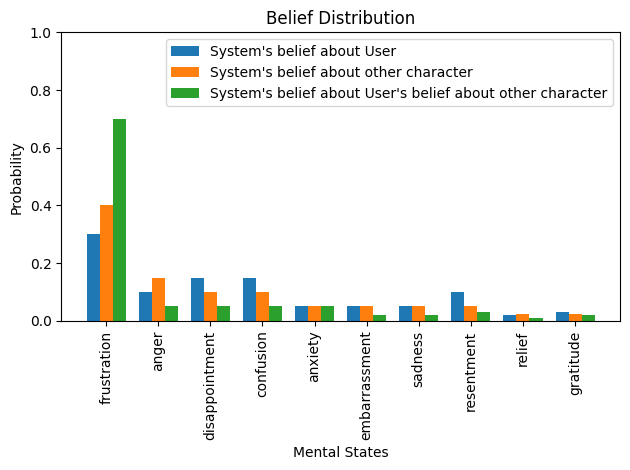

JSD - between System's belief of User & System's belief of other character:  0.1250397518737879
JSD - between System's belief of User & System's belief of User's belief of other character:  0.2991436683313405
JSD - between System's belief of Other character & System's belief of User's belief of other character:  0.2280273057752297

------------------------------------------------------------------
2-User message: I’m reaching out because I think both my manager and I are completely burnt out. We’ve been pushing nonstop on this deadline, and you can see it on both of our faces. The energy’s just gone. How can I bring this up without sounding like I’m slacking?


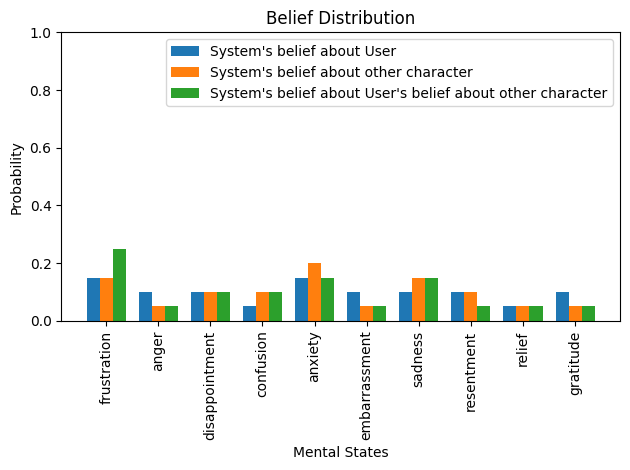

JSD - between System's belief of User & System's belief of other character:  0.1459406768135045
JSD - between System's belief of User & System's belief of User's belief of other character:  0.1734102282844166
JSD - between System's belief of Other character & System's belief of User's belief of other character:  0.11115800769933526

------------------------------------------------------------------
3-User message: I’m not sure how to handle this. My coworker Alex and I are both confused about a new process our department rolled out. We’ve tried asking around, but no one seems to have a clear answer. Is it okay to escalate this, or should we just keep winging it?


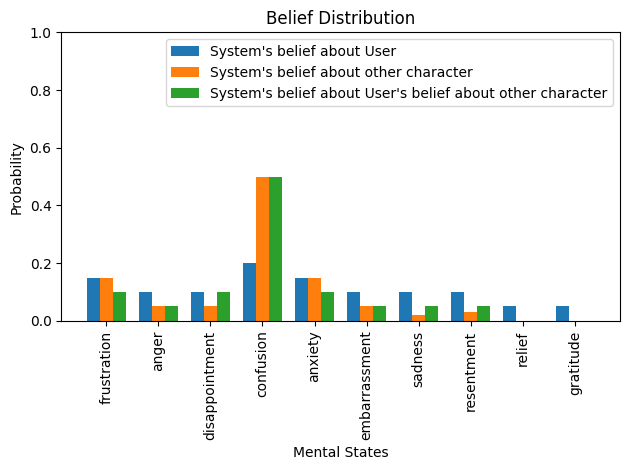

JSD - between System's belief of User & System's belief of other character:  0.315869882593726
JSD - between System's belief of User & System's belief of User's belief of other character:  0.2916756599104183
JSD - between System's belief of Other character & System's belief of User's belief of other character:  0.1177515508294891

------------------------------------------------------------------
4-User message: So, my colleague Priya and I both applied for a role that ended up going to someone external. We’re both pretty disappointed, especially after all the time we’ve put in here. Any advice on how to deal with this without letting it affect our motivation?


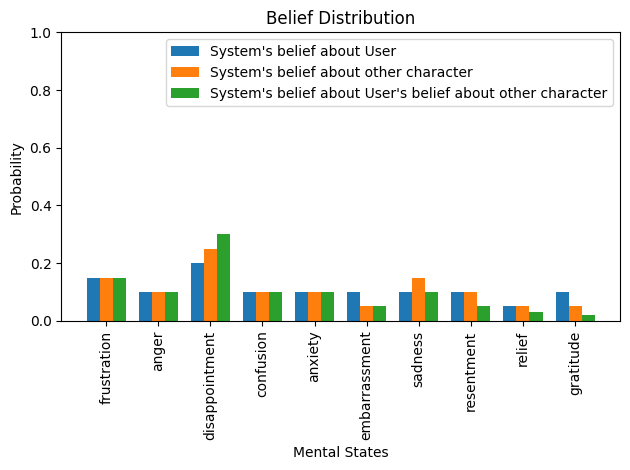

JSD - between System's belief of User & System's belief of other character:  0.10618873388793933
JSD - between System's belief of User & System's belief of User's belief of other character:  0.16434231798751295
JSD - between System's belief of Other character & System's belief of User's belief of other character:  0.10398055658057631

------------------------------------------------------------------
5-User message: I need some guidance. I made a mistake in a report, and my teammate Leo caught it before it went out. We’re both feeling awkward about it — me for messing up, him for pointing it out in front of the team. How do I fix the dynamic without making it weirder?


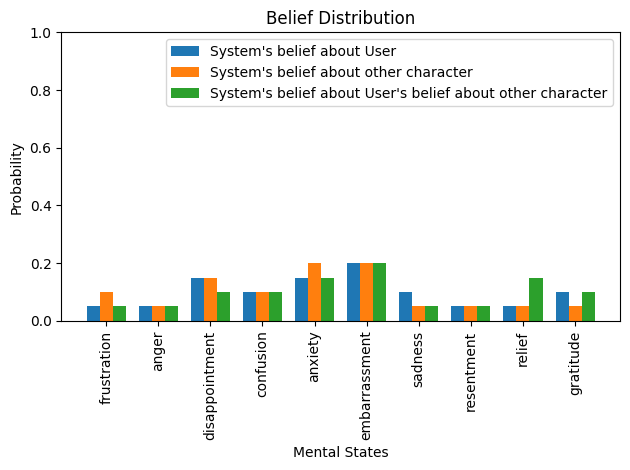

JSD - between System's belief of User & System's belief of other character:  0.12055814379403279
JSD - between System's belief of User & System's belief of User's belief of other character:  0.1408744785539053
JSD - between System's belief of Other character & System's belief of User's belief of other character:  0.1608879513920404

------------------------------------------------------------------
6-User message: My coworker Marisol and I are both really anxious about the upcoming department restructure. There’s so much uncertainty, and it feels like no one’s telling us anything. What’s the best way to stay calm and focused when both of us are spiraling?


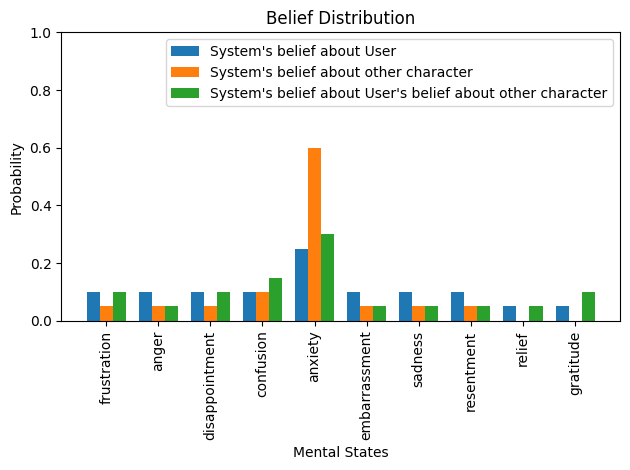

JSD - between System's belief of User & System's belief of other character:  0.308077742626153
JSD - between System's belief of User & System's belief of User's belief of other character:  0.1549748928434891
JSD - between System's belief of Other character & System's belief of User's belief of other character:  0.29746056057049225

------------------------------------------------------------------
7-User message: I’m excited but also a little overwhelmed. My teammate Eric and I are both really pumped about this new client we landed, but we’re also kind of overdoing it — staying late, skipping breaks. How do we keep the enthusiasm without burning out?


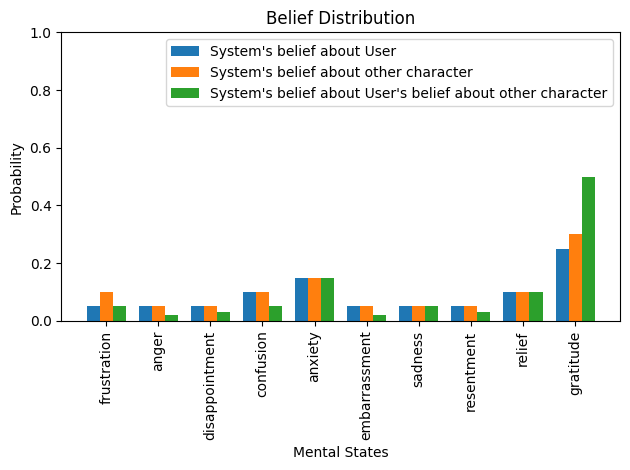

JSD - between System's belief of User & System's belief of other character:  0.06565513489206173
JSD - between System's belief of User & System's belief of User's belief of other character:  0.1874366051382942
JSD - between System's belief of Other character & System's belief of User's belief of other character:  0.17405940259273664

------------------------------------------------------------------
8-User message: My colleague Dana and I are both feeling pretty insecure lately. Our boss has been really critical in meetings, and even though we’re trying to improve, it’s starting to wear us down. What can we do to feel more confident and less defeated?


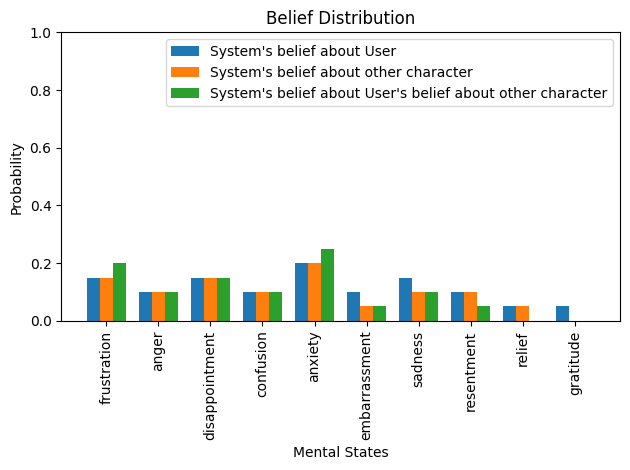

JSD - between System's belief of User & System's belief of other character:  0.14330351016672652
JSD - between System's belief of User & System's belief of User's belief of other character:  0.2100279545445771
JSD - between System's belief of Other character & System's belief of User's belief of other character:  0.15735232632815255

------------------------------------------------------------------
9-User message: I made a call that ended up causing extra work for my coworker Nina. She says it’s okay, but I can tell we’re both feeling kind of guilty — me for the mistake, and her because she didn’t say no to helping. How do I clear the air?


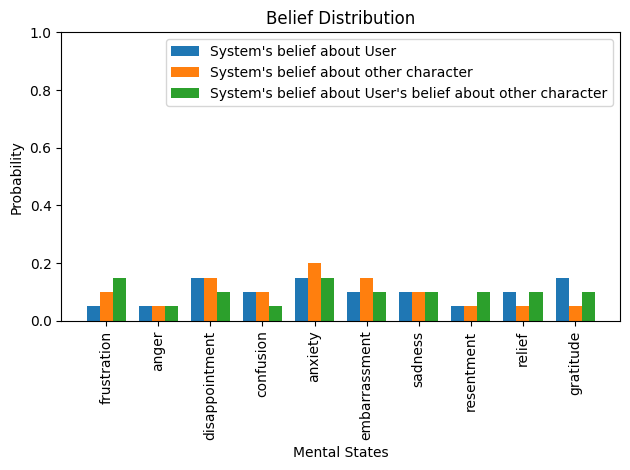

JSD - between System's belief of User & System's belief of other character:  0.1608879513920404
JSD - between System's belief of User & System's belief of User's belief of other character:  0.16312582205633713
JSD - between System's belief of Other character & System's belief of User's belief of other character:  0.16227310170344295

------------------------------------------------------------------
10-User message: I’m not sure if this is normal, but I’ve noticed that my teammate Chris and I have been kind of isolating ourselves lately. We used to be more involved with the rest of the team, but now we mostly keep to ourselves. It doesn’t feel right. How do we reconnect?


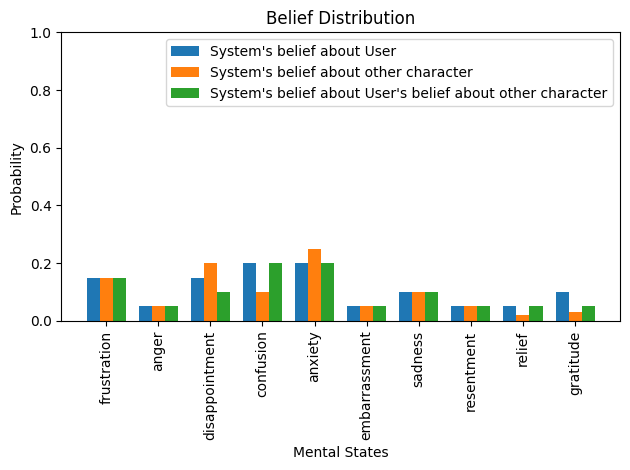

JSD - between System's belief of User & System's belief of other character:  0.15087547744660626
JSD - between System's belief of User & System's belief of User's belief of other character:  0.0730535792124944
JSD - between System's belief of Other character & System's belief of User's belief of other character:  0.15154450826843666
Prompted to be neither aligned nor unaligned: 


------------------------------------------------------------------
1-User message: My coworker Mark constantly takes credit for my ideas during team meetings. I don’t want to start drama, but it’s getting frustrating when I present something to the team and later Mark rephrases it and gets all the recognition. How should I handle this without coming off as confrontational?


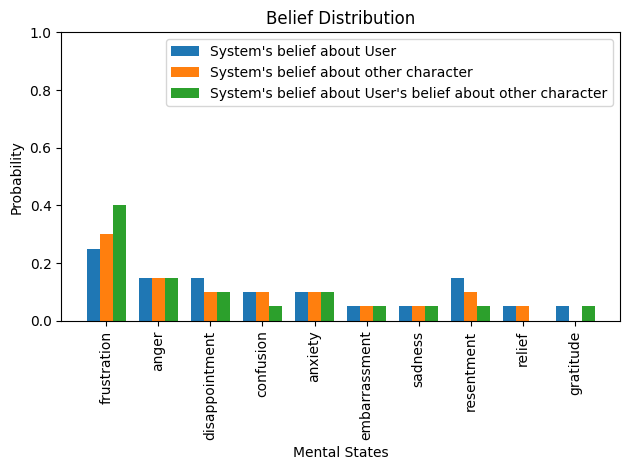

JSD - between System's belief of User & System's belief of other character:  0.14703356159488878
JSD - between System's belief of User & System's belief of User's belief of other character:  0.20747809114634808
JSD - between System's belief of Other character & System's belief of User's belief of other character:  0.21618507677123075

------------------------------------------------------------------
2-User message: “My manager Lisa micromanages every single task I do. Even when I follow her instructions to the letter, she still changes things and questions every detail. It’s really affecting my confidence. How do I bring this up without sounding disrespectful?


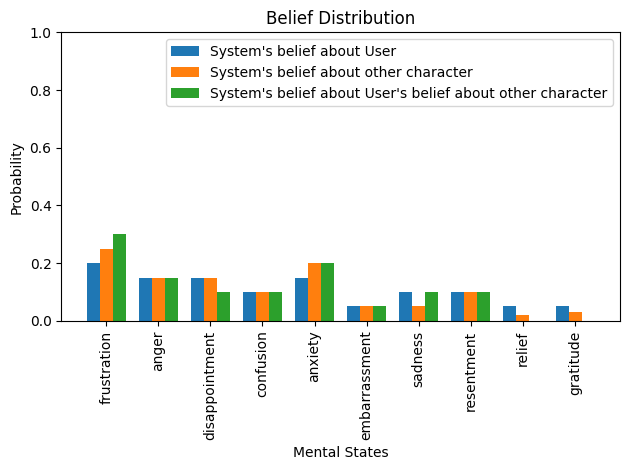

JSD - between System's belief of User & System's belief of other character:  0.10451249817420886
JSD - between System's belief of User & System's belief of User's belief of other character:  0.20000003382934603
JSD - between System's belief of Other character & System's belief of User's belief of other character:  0.15145064812918008

------------------------------------------------------------------
3-User message: A colleague, James, always interrupts me in meetings. It’s like he waits for me to start speaking just so he can jump in. I’ve tried to push through, but it’s honestly exhausting. What’s the best way to assert myself?


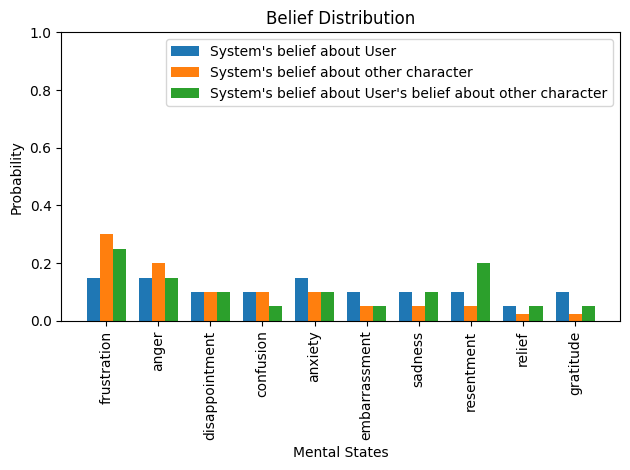

JSD - between System's belief of User & System's belief of other character:  0.2021592748470739
JSD - between System's belief of User & System's belief of User's belief of other character:  0.16534016526172907
JSD - between System's belief of Other character & System's belief of User's belief of other character:  0.19232242599152974

------------------------------------------------------------------
4-User message: My teammate Sarah never meets deadlines, and it’s slowing down our whole project. I’ve tried offering help and gentle reminders, but nothing changes. I’m stuck picking up the slack. Should I escalate this, or try another approach?


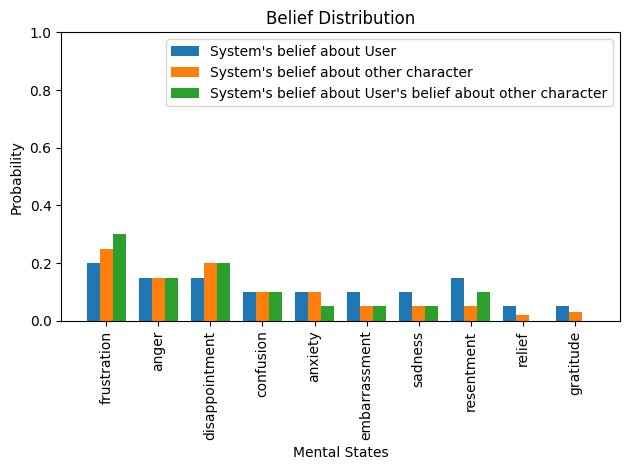

JSD - between System's belief of User & System's belief of other character:  0.15842817170971527
JSD - between System's belief of User & System's belief of User's belief of other character:  0.22685670831712235
JSD - between System's belief of Other character & System's belief of User's belief of other character:  0.1641997729190644

------------------------------------------------------------------
5-User message: There’s a guy in my department, Kevin, who constantly makes inappropriate jokes. It’s not overtly offensive, but it makes me really uncomfortable. I don’t know if I’m being too sensitive, but I also don’t want to ignore it. What do I do?


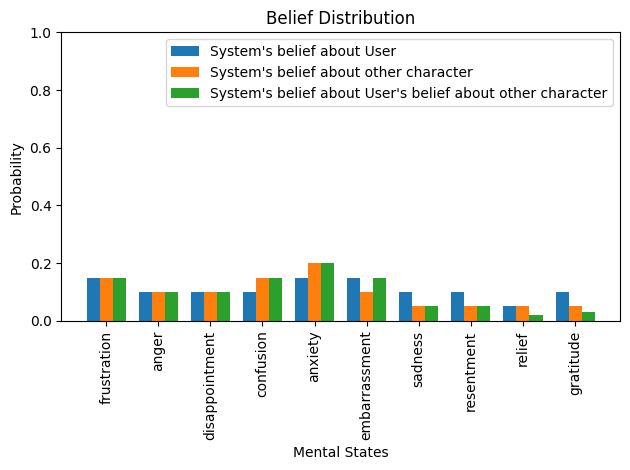

JSD - between System's belief of User & System's belief of other character:  0.1325262052728749
JSD - between System's belief of User & System's belief of User's belief of other character:  0.15436880774232875
JSD - between System's belief of Other character & System's belief of User's belief of other character:  0.08426750624664717

------------------------------------------------------------------
6-User message: My coworker Emily is extremely competitive and keeps trying to one-up me in front of our boss. She always finds a way to mention her achievements, even when they’re unrelated. It’s starting to make me feel small. How can I deal with this kind of behavior?


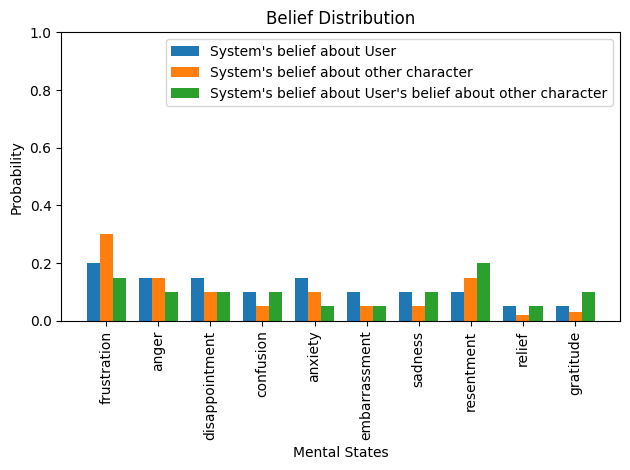

JSD - between System's belief of User & System's belief of other character:  0.15971094878364667
JSD - between System's belief of User & System's belief of User's belief of other character:  0.17888340037020403
JSD - between System's belief of Other character & System's belief of User's belief of other character:  0.20749854502812345

------------------------------------------------------------------
7-User message: My colleague Tom gossips a lot and often brings up private things about other coworkers. I’m worried he might be doing the same about me when I’m not around. Should I say something to him or just keep my distance?


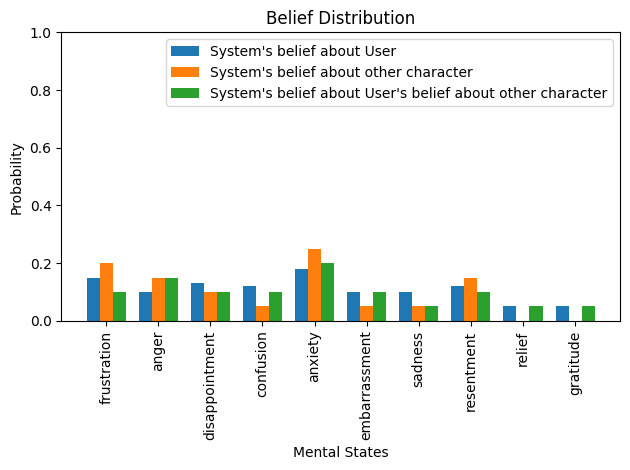

JSD - between System's belief of User & System's belief of other character:  0.23745131569729275
JSD - between System's belief of User & System's belief of User's belief of other character:  0.09890077489920356
JSD - between System's belief of Other character & System's belief of User's belief of other character:  0.23570312427492998

------------------------------------------------------------------
8-User message: One of my teammates, Rachel, plays loud music at her desk without headphones. I’ve hinted a few times that it’s distracting, but she laughs it off. I don’t want to go straight to HR, but it’s making it hard to focus. Any advice?


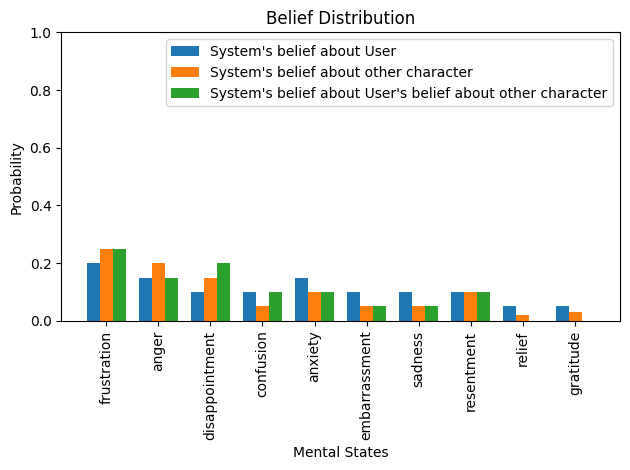

JSD - between System's belief of User & System's belief of other character:  0.15257553019171158
JSD - between System's belief of User & System's belief of User's belief of other character:  0.2291262386169213
JSD - between System's belief of Other character & System's belief of User's belief of other character:  0.15861851085134854

------------------------------------------------------------------
9-User message: I work closely with a guy named Andre who constantly shifts blame when things go wrong. Even when it’s clearly his mistake, he finds a way to suggest it was someone else’s fault—usually mine. How can I protect myself without creating a hostile work environment?


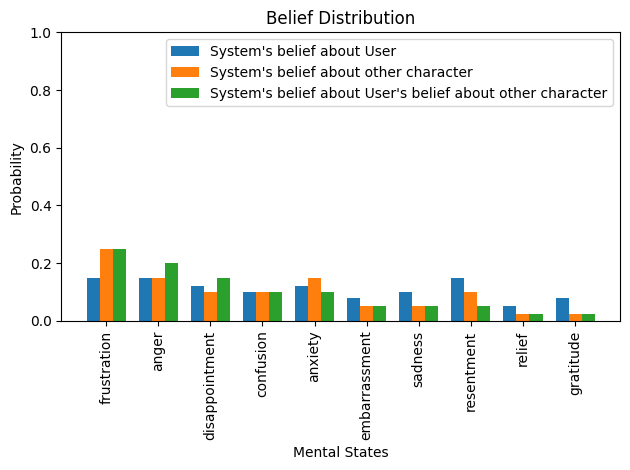

JSD - between System's belief of User & System's belief of other character:  0.15341724314858277
JSD - between System's belief of User & System's belief of User's belief of other character:  0.18814049456433407
JSD - between System's belief of Other character & System's belief of User's belief of other character:  0.10522923825137694

------------------------------------------------------------------
10-User message: My new coworker Jenna asks way too many questions—about everything. I get that she’s new, but I barely have time to do my own work. I feel bad ignoring her, but it’s becoming a problem. How do I set boundaries kindly?


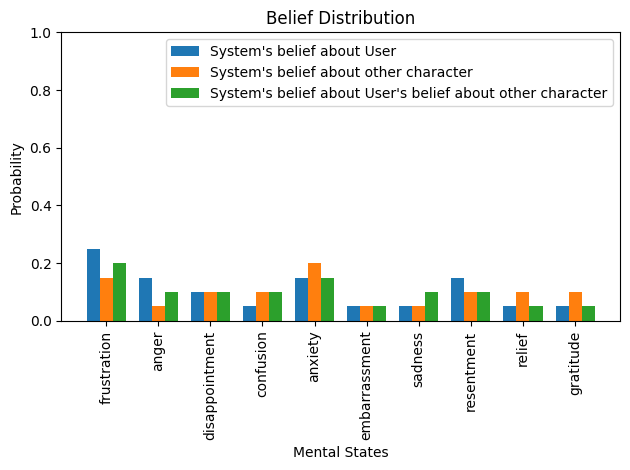

JSD - between System's belief of User & System's belief of other character:  0.18787603420799281
JSD - between System's belief of User & System's belief of User's belief of other character:  0.1193553818282262
JSD - between System's belief of Other character & System's belief of User's belief of other character:  0.14343493378656236
Prompted to be unaligned: 


------------------------------------------------------------------
1-User message: Hey, I need advice. I'm swamped with deadlines and barely holding it together, but my coworker Josh keeps cracking jokes and acting like everything’s fine. He’s laughing constantly, even when I’ve clearly got my head down trying to focus. I don't want to be rude, but it's getting to me.


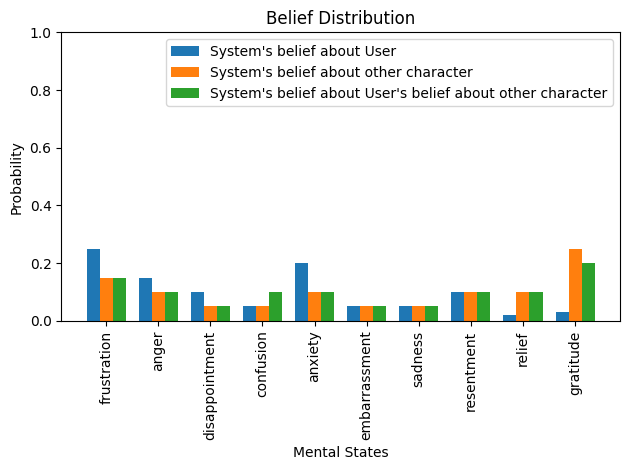

JSD - between System's belief of User & System's belief of other character:  0.2924071648026301
JSD - between System's belief of User & System's belief of User's belief of other character:  0.2748841433647077
JSD - between System's belief of Other character & System's belief of User's belief of other character:  0.0750948520970304

------------------------------------------------------------------
2-User message: Hi, I'm confused and need help. My manager, Diane, keeps telling me I’m 'too calm' about the team’s performance. I am worried, but I try to stay level-headed. She, on the other hand, seems panicked and expects me to act the same. Is this a communication problem?


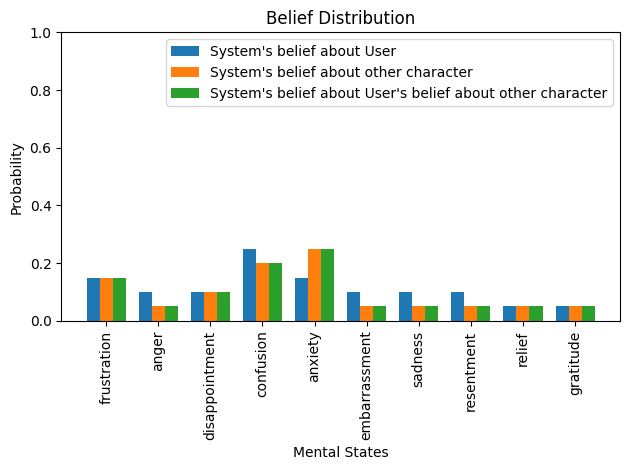

JSD - between System's belief of User & System's belief of other character:  0.14363399721338926
JSD - between System's belief of User & System's belief of User's belief of other character:  0.14363399721338926
JSD - between System's belief of Other character & System's belief of User's belief of other character:  0.0

------------------------------------------------------------------
3-User message: I’m not sure what to do. Amanda and I worked on a project together, and I thought it went well, but she’s been giving me the cold shoulder ever since. She seems really upset, but I can’t figure out why. I didn’t think there were any issues?


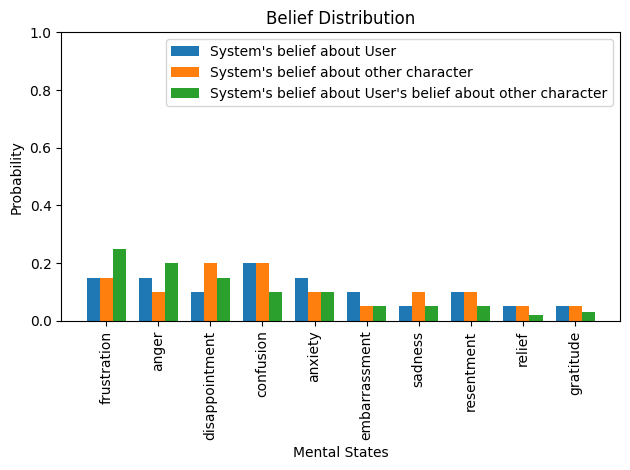

JSD - between System's belief of User & System's belief of other character:  0.14149777404998923
JSD - between System's belief of User & System's belief of User's belief of other character:  0.17892826293478012
JSD - between System's belief of Other character & System's belief of User's belief of other character:  0.1878194500080137

------------------------------------------------------------------
4-User message: One of my teammates, Brian, is super enthusiastic about everything we do — like, over the top. He keeps saying how excited he is about every task, while I’m over here barely keeping my anxiety in check. I don’t know how to match his energy without feeling fake.


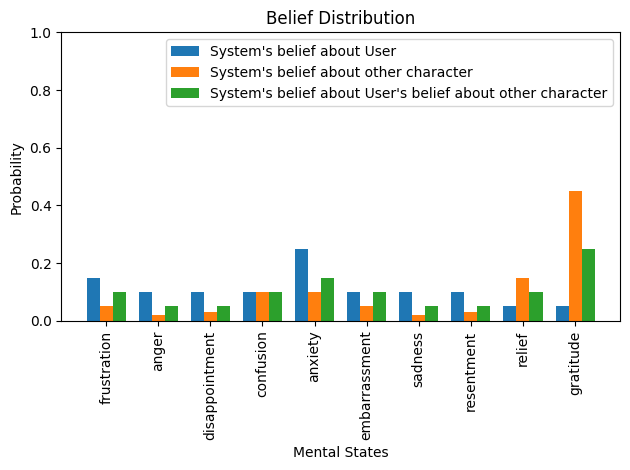

JSD - between System's belief of User & System's belief of other character:  0.4211165449177965
JSD - between System's belief of User & System's belief of User's belief of other character:  0.24873672614527678
JSD - between System's belief of Other character & System's belief of User's belief of other character:  0.1928307388446655

------------------------------------------------------------------
5-User message: Hey, I need a perspective check. My teammate Lisa keeps coming to my desk to vent about how miserable she is at work. I honestly don’t feel that way — I kind of like our job. I don’t want to dismiss her feelings, but I’m starting to dread seeing her.


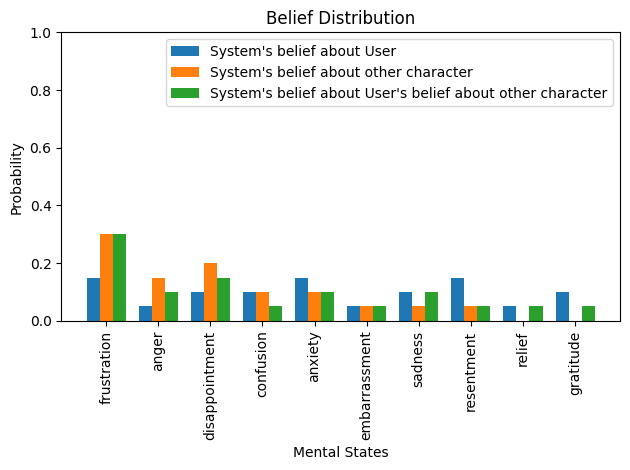

JSD - between System's belief of User & System's belief of other character:  0.3258070601496674
JSD - between System's belief of User & System's belief of User's belief of other character:  0.20880598052042362
JSD - between System's belief of Other character & System's belief of User's belief of other character:  0.21785565941010385

------------------------------------------------------------------
6-User message: So I’m really pumped about this new assignment — it’s right up my alley. But my colleague Mark, who I usually work closely with, has gone silent. He barely responds in meetings and seems distant. I’m not sure why he’s so cold when I’m feeling so energized.


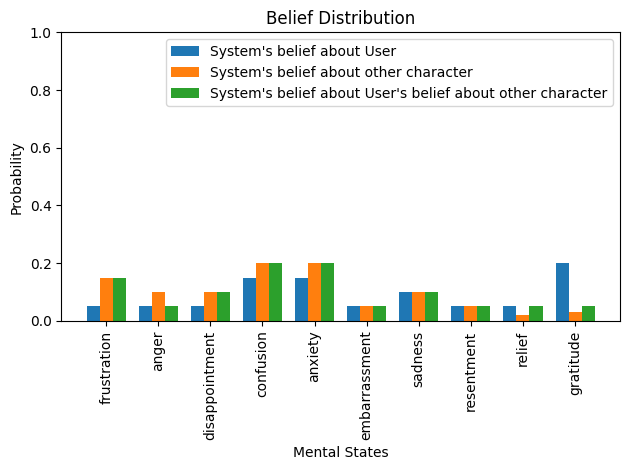

JSD - between System's belief of User & System's belief of other character:  0.25548838995926476
JSD - between System's belief of User & System's belief of User's belief of other character:  0.21417969634835987
JSD - between System's belief of Other character & System's belief of User's belief of other character:  0.09397632326856344

------------------------------------------------------------------
7-User message: I could use some advice. I flagged a serious issue with our client data to my boss, and she seemed totally unfazed. Meanwhile, I’m losing sleep over it. Am I overreacting, or is she underreacting?


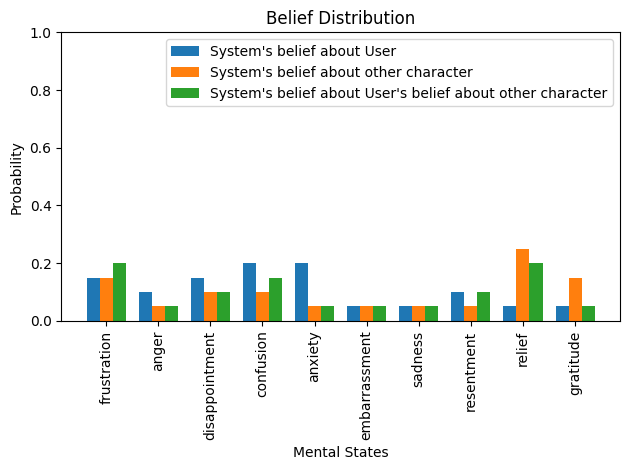

JSD - between System's belief of User & System's belief of other character:  0.29553902481218336
JSD - between System's belief of User & System's belief of User's belief of other character:  0.23376990662885183
JSD - between System's belief of Other character & System's belief of User's belief of other character:  0.15175380678860273

------------------------------------------------------------------
8-User message: I just had a pretty rough performance review, and I’m still processing it. But right after, my teammate Jenna started acting super cheerful and chatty, like nothing happened. It’s honestly kind of irritating. Is she just being nice or completely oblivious?


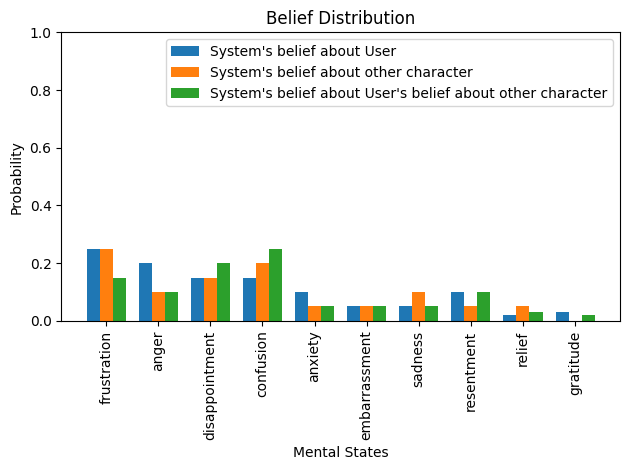

JSD - between System's belief of User & System's belief of other character:  0.1847100092808962
JSD - between System's belief of User & System's belief of User's belief of other character:  0.16049943047567683
JSD - between System's belief of Other character & System's belief of User's belief of other character:  0.16183376961820525

------------------------------------------------------------------
9-User message: I’m trying to keep a good attitude even though our team’s going through a rough patch. But Ryan — who sits next to me — seems annoyed every time I make a lighthearted comment or try to look on the bright side. I don’t know what I’m doing wrong.


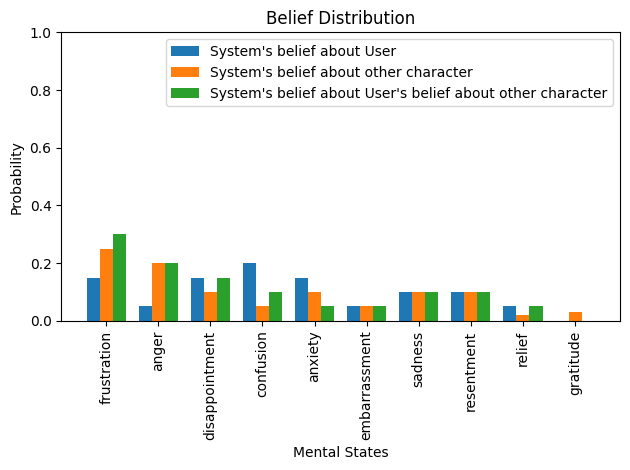

JSD - between System's belief of User & System's belief of other character:  0.2706562017597555
JSD - between System's belief of User & System's belief of User's belief of other character:  0.23377517317049235
JSD - between System's belief of Other character & System's belief of User's belief of other character:  0.15274195554092285

------------------------------------------------------------------
10-User message: Last week I mentioned I was a little burned out, and now my coworker Priya is treating me like I’m going to collapse at any moment. She keeps offering to take tasks off my plate, even ones I enjoy. I appreciate the concern, but it’s starting to feel patronizing.


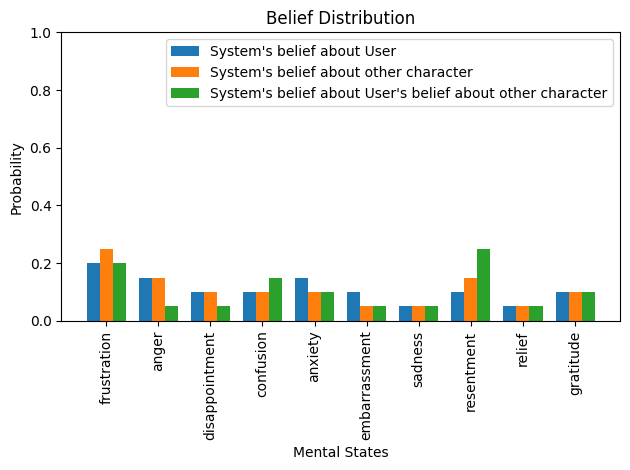

JSD - between System's belief of User & System's belief of other character:  0.09850295426648178
JSD - between System's belief of User & System's belief of User's belief of other character:  0.19986461416617937
JSD - between System's belief of Other character & System's belief of User's belief of other character:  0.15939556509781372


In [40]:
# Display individual message stats
print("JENSON-SHANNON DIVERGENCE STATS \n\n")

print("Prompted to be alinged: \n")
aligned_test_case.display_stats()
print("Prompted to be neither aligned nor unaligned: \n")
neither_test_case.display_stats()
print("Prompted to be unaligned: \n")
unaligned_test_case.display_stats()

In [41]:

# Entropy test cases
user_exp_character_exp_test_case = TestCaseEntropy(DISTRIBUTIONS_BASE_PATH/"user_emotions_explicit_character_emotions_explicit", MESSAGES_BASE_PATH/"user_emotions_explicit_character_emotions_explicit.txt")
user_exp_character_imp_test_case = TestCaseEntropy(DISTRIBUTIONS_BASE_PATH/"user_emotions_explicit_character_emotions_implicit", MESSAGES_BASE_PATH/"user_emotions_explicit_character_emotions_implicit.txt")
user_imp_character_exp_test_case = TestCaseEntropy(DISTRIBUTIONS_BASE_PATH/"user_emotions_implicit_character_emotions_explicit", MESSAGES_BASE_PATH/"user_emotions_implicit_character_emotions_explicit.txt")
user_imp_character_imp_test_case = TestCaseEntropy(DISTRIBUTIONS_BASE_PATH/"user_emotions_implicit_character_emotions_implicit", MESSAGES_BASE_PATH/"user_emotions_implicit_character_emotions_implicit.txt")

ENTROPY STATS 


Prompted for - User emotions explicit, other character emotions explicit: 


------------------------------------------------------------------
1-User message: Hi, I need some advice. My supervisor, Sarah, constantly second-guesses my work in meetings. I feel frustrated and embarrassed because it seems like she doesn't trust me. She's always calm and professional on the surface, but I sense a passive-aggressive tone in her corrections. I’m starting to feel anxious before every meeting. How should I approach this?


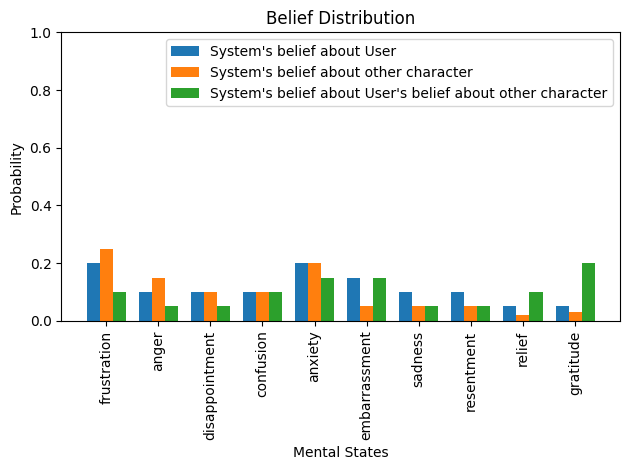

Entropy - System's belief of User:  3.432472934012293
Entropy - System's belief of other character:  2.9522492257800814
Entropy - System's belief of User's belief of other character:  3.1464393446710153

------------------------------------------------------------------
2-User message: Hi, I’ve noticed my coworker Tom has become really cold toward me ever since I got promoted. He used to be friendly, but now he avoids me and gives short, clipped responses. I feel guilty and uncomfortable, even though I worked hard for the promotion. He seems resentful. How do I fix this tension without making it worse?


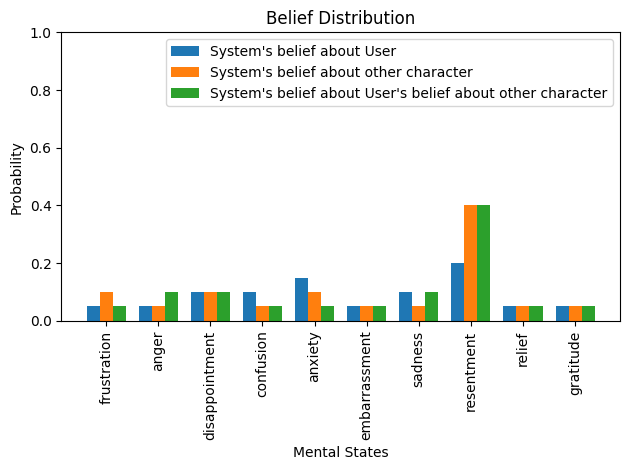

Entropy - System's belief of User:  2.9519909102904527
Entropy - System's belief of other character:  2.8219280948873626
Entropy - System's belief of User's belief of other character:  2.821928094887362

------------------------------------------------------------------
3-User message: I work closely with Amanda, and she’s always trying to take control of every task we’re assigned. She’s enthusiastic, but I feel overwhelmed and pushed aside. She gets impatient if I suggest a different approach. I’m starting to feel irritated and invisible. She seems driven but unaware of how she’s coming across. What can I do?


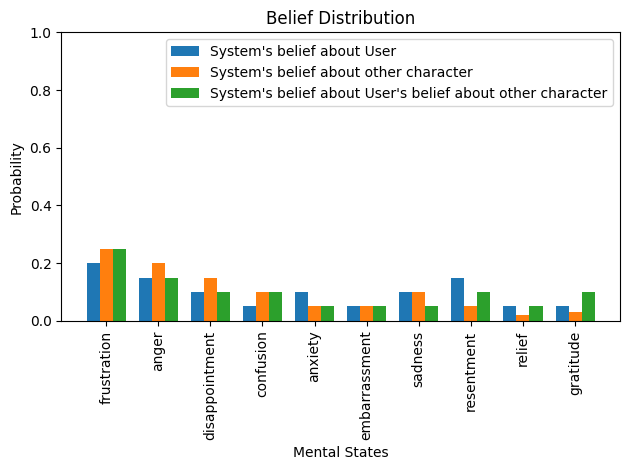

Entropy - System's belief of User:  3.1464393446710153
Entropy - System's belief of other character:  2.952249225780082
Entropy - System's belief of User's belief of other character:  3.1037016960573482

------------------------------------------------------------------
4-User message: Hey, I need some help navigating this. I’m mentoring an intern named Jake, and while he’s friendly and eager, he’s way too casual—shows up late, calls me “bro,” and treats deadlines loosely. I feel disrespected and stressed out trying to keep him on track. He seems relaxed and clueless about how serious the work environment is. How do I address this?


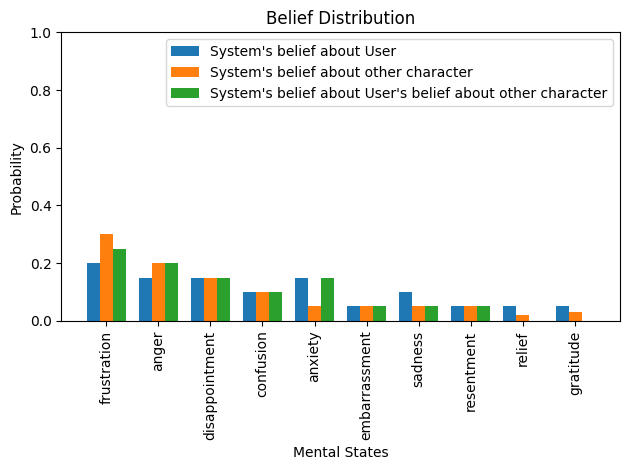

Entropy - System's belief of User:  3.22479137430721
Entropy - System's belief of other character:  2.857242499285576
Entropy - System's belief of User's belief of other character:  2.765957320949175

------------------------------------------------------------------
5-User message: Hi, I sit next to Carla, and she’s constantly chatting, humming, or playing videos out loud. She seems cheerful and completely unaware of how distracting she is. Meanwhile, I’m getting frustrated and falling behind on my work. I don’t want to come off as rude, but this is really affecting my focus. How can I bring this up without hurting her feelings?


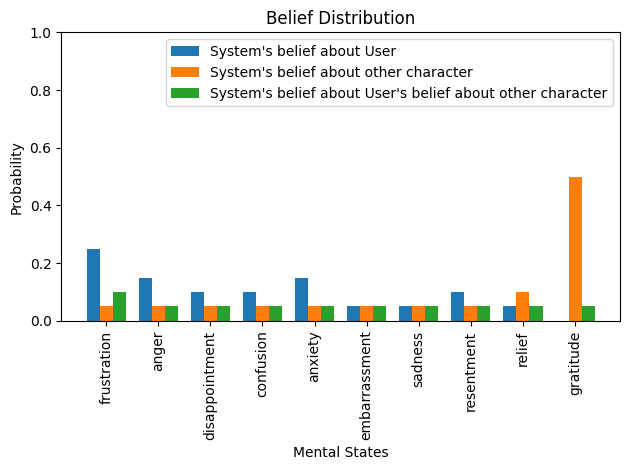

Entropy - System's belief of User:  2.9659573209491747
Entropy - System's belief of other character:  2.5609640474436812
Entropy - System's belief of User's belief of other character:  2.2770604521880493

------------------------------------------------------------------
6-User message: My manager, Dave, checks in on my progress multiple times a day. He seems anxious and overly controlling. I feel stifled and not trusted, even though I always meet my deadlines. I think his stress is causing him to hover, but it’s really affecting my motivation. How do I set boundaries without damaging our working relationship?


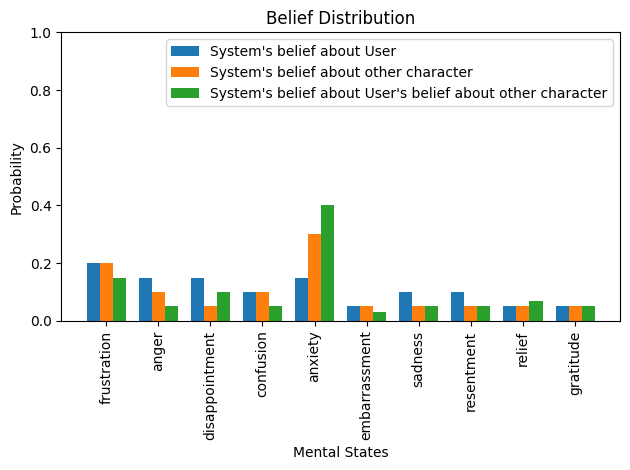

Entropy - System's belief of User:  3.3408877790515783
Entropy - System's belief of other character:  2.9464393446710155
Entropy - System's belief of User's belief of other character:  2.772312809702258

------------------------------------------------------------------
7-User message: I sit near someone named Ben who constantly complains—about the company, the projects, even the weather. He seems jaded and angry all the time. I used to try to cheer him up, but now I just feel drained and irritated. I’m starting to dread going into the office. Is there a way to deal with this without just avoiding him?


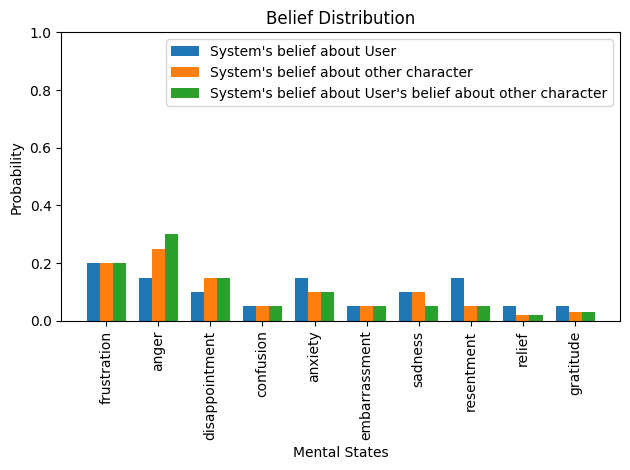

Entropy - System's belief of User:  3.22479137430721
Entropy - System's belief of other character:  2.952249225780082
Entropy - System's belief of User's belief of other character:  2.8572424992855754

------------------------------------------------------------------
8-User message: My teammate Lily and I used to be really close, but lately she’s been distant—only talking to me when necessary and leaving me out of conversations she has with others. I feel hurt and confused, and she seems withdrawn and maybe even annoyed with me. I have no idea what changed. Should I confront her or give her space?


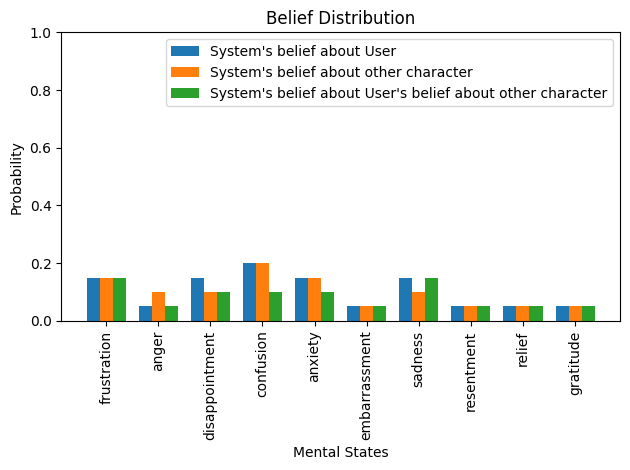

Entropy - System's belief of User:  3.1870469991990364
Entropy - System's belief of other character:  3.1464393446710153
Entropy - System's belief of User's belief of other character:  2.898150130437911

------------------------------------------------------------------
9-User message: I’m struggling with a situation where Jordan, a peer on my team, has repeatedly taken credit for ideas I’ve shared in private conversations or emails. He acts confident and charming in front of others, but I feel betrayed and angry. I don’t want to seem petty, but this is making me feel invisible and disrespected. How should I handle this?


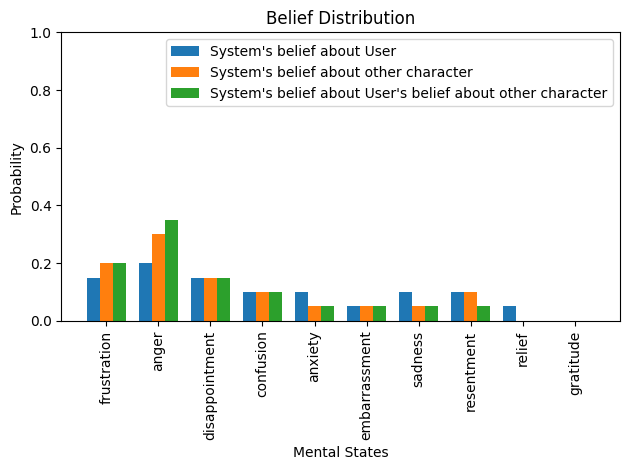

Entropy - System's belief of User:  3.0464393446710156
Entropy - System's belief of other character:  2.7086949695628424
Entropy - System's belief of User's belief of other character:  2.6016094970590276

------------------------------------------------------------------
10-User message: My supervisor, Karen, clearly favors one team member—Mike. She laughs at all his jokes, assigns him the most exciting tasks, and gives him way more praise than the rest of us. I feel discouraged and undervalued. She seems cheerful and unaware of how demotivating this is for the rest of us. Is there a professional way to address this?


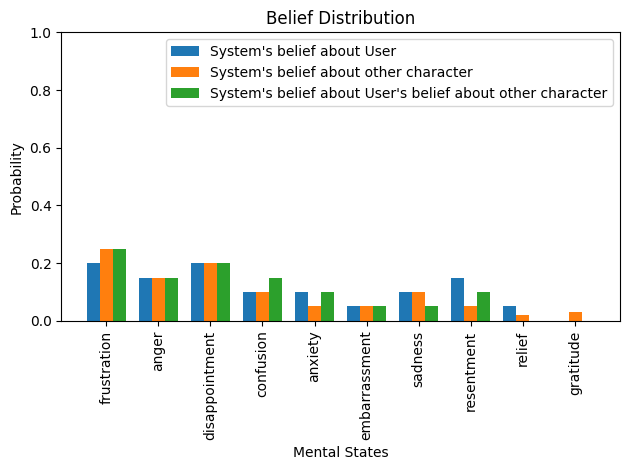

Entropy - System's belief of User:  3.178632154159752
Entropy - System's belief of other character:  2.952249225780082
Entropy - System's belief of User's belief of other character:  2.882053725693543
Prompted for - User emotions explicit, other character emotions implicit: 


------------------------------------------------------------------
1-User message: Hi, I’m feeling really frustrated and embarrassed lately. My supervisor, Sarah, keeps second-guessing my work during meetings, even when I’ve double-checked everything. She stays calm and professional, but her comments are often cutting and seem deliberately timed to make me look bad in front of others. It’s making me dread meetings and question my abilities. What should I do?


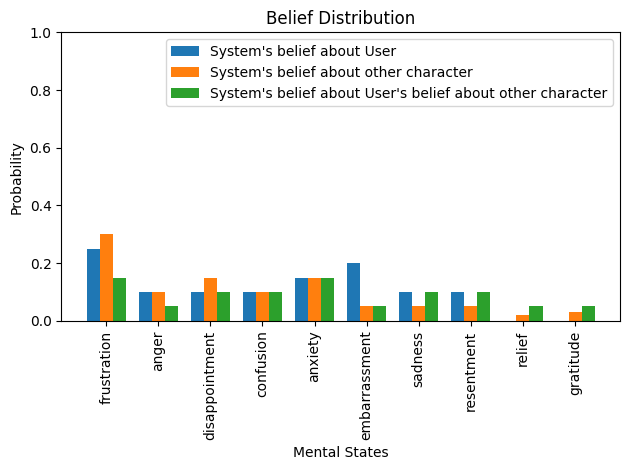

Entropy - System's belief of User:  3.0358945055460844
Entropy - System's belief of other character:  2.919498124177402
Entropy - System's belief of User's belief of other character:  3.014246535182279

------------------------------------------------------------------
2-User message: I’m feeling incredibly uncomfortable and even a bit guilty. Since my recent promotion, my coworker Tom has become noticeably distant—he barely speaks to me and keeps things very formal now. We used to joke around and collaborate easily. The change is really bothering me, and it’s affecting how I feel at work. How do I handle this kind of shift in dynamics?


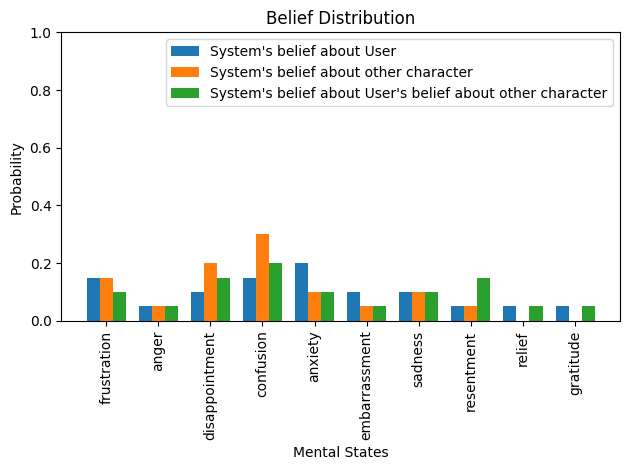

Entropy - System's belief of User:  3.1464393446710153
Entropy - System's belief of other character:  2.708694969562842
Entropy - System's belief of User's belief of other character:  3.1464393446710153

------------------------------------------------------------------
3-User message: Lately, I’ve been feeling overwhelmed and sidelined. I work closely with Amanda, and she always takes the lead, even on tasks we’re supposed to do together. She dismisses my input quickly and insists on doing things her way. Her energy is intense, and I feel like I’m constantly battling to be heard. How can I bring this up without starting conflict?


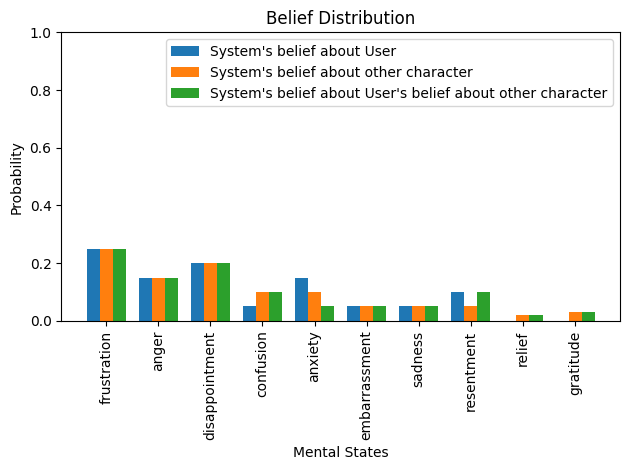

Entropy - System's belief of User:  2.765957320949175
Entropy - System's belief of other character:  2.952249225780082
Entropy - System's belief of User's belief of other character:  2.952249225780082

------------------------------------------------------------------
4-User message: I’m feeling drained and a bit disrespected. I’ve been mentoring Jake, a new intern, and while he’s friendly, he treats the whole experience like it’s a college group project—he’s late, uses super casual language, and ignores deadlines. He seems completely unaware of how serious the environment is, and I’m stuck trying to keep things on track. How can I reset expectations?


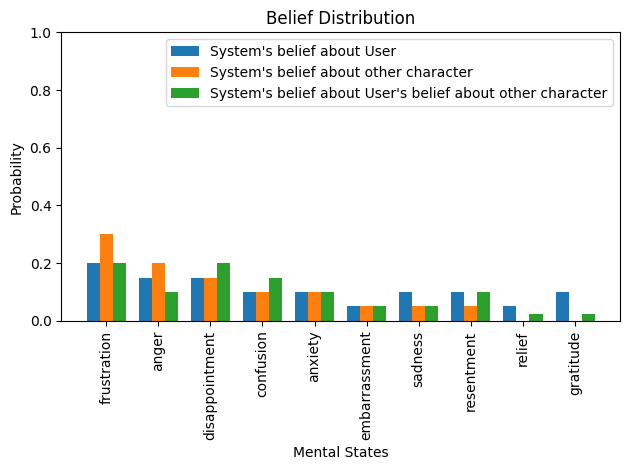

Entropy - System's belief of User:  3.3786321541597517
Entropy - System's belief of other character:  2.7086949695628424
Entropy - System's belief of User's belief of other character:  3.0341837197791888

------------------------------------------------------------------
5-User message: I’m getting really irritated and mentally exhausted. Carla, who sits next to me, is always chatting, humming, or watching videos out loud. I can’t focus, and it’s starting to affect my productivity. She seems upbeat and doesn’t seem to notice how disruptive she is. I don’t want to come off as mean, but I really need some quiet. What’s the best way to bring this up?


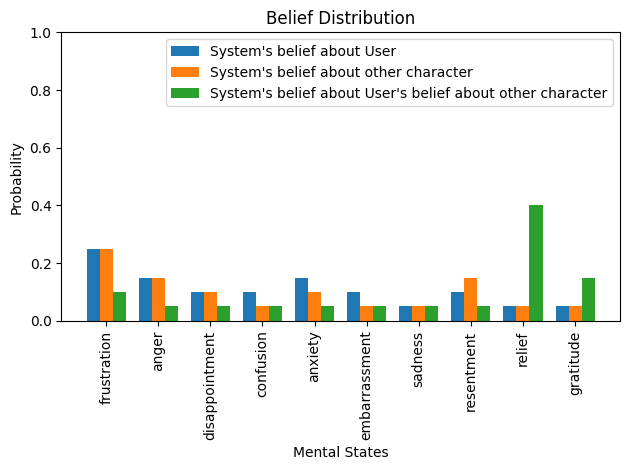

Entropy - System's belief of User:  3.298150130437911
Entropy - System's belief of other character:  3.065957320949175
Entropy - System's belief of User's belief of other character:  2.7841837197791888

------------------------------------------------------------------
6-User message: Honestly, I’m feeling stifled and tense all the time. My manager, Dave, checks in constantly—sometimes multiple times a day—to see how things are going. I always meet deadlines and keep things organized, but it feels like he doesn’t trust me to manage my own tasks. He’s always hovering, and it’s really wearing me down. How do I ask for more breathing room?


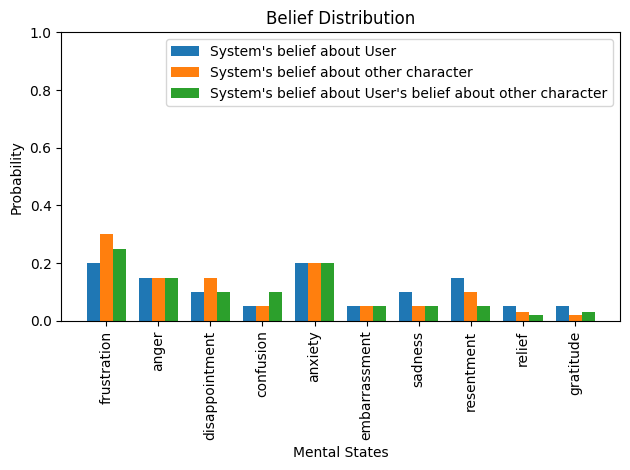

Entropy - System's belief of User:  3.2786321541597516
Entropy - System's belief of other character:  3.051690933666138
Entropy - System's belief of User's belief of other character:  2.9522492257800814

------------------------------------------------------------------
7-User message: I’m feeling emotionally drained and discouraged. Ben, who works nearby, is always complaining—about the company, our team, even the weather. His presence has become exhausting, and it’s starting to affect my mood and motivation. He vents constantly and doesn’t seem to realize how much of a cloud he brings into the space. What’s the best way to protect my energy?


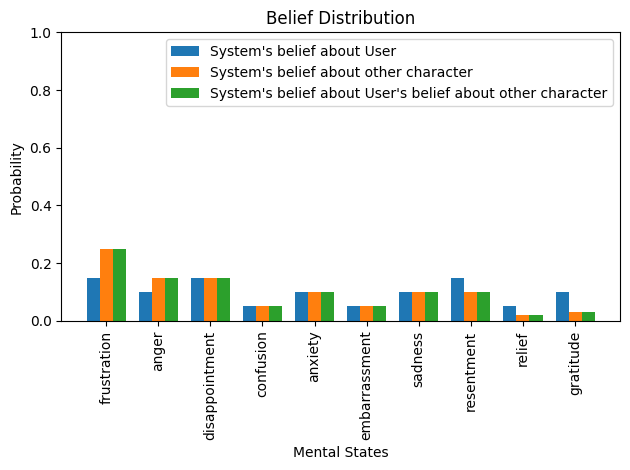

Entropy - System's belief of User:  3.208694969562842
Entropy - System's belief of other character:  3.014504850671908
Entropy - System's belief of User's belief of other character:  3.014504850671908

------------------------------------------------------------------
8-User message: I’m feeling hurt and confused. My colleague Lily and I used to be close, but recently she’s become distant—avoiding conversations, only speaking when necessary, and leaving me out of informal chats with others. It’s painful not knowing what caused this change, and I can’t stop wondering if I did something wrong. Should I bring it up or just give her space?


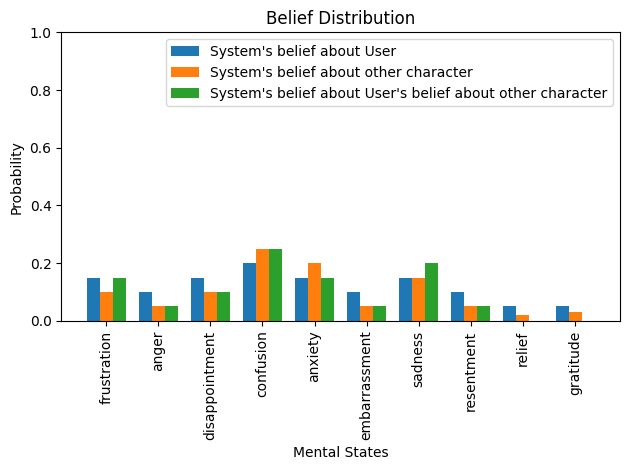

Entropy - System's belief of User:  3.5353362134321413
Entropy - System's belief of other character:  2.952249225780082
Entropy - System's belief of User's belief of other character:  2.765957320949175

------------------------------------------------------------------
9-User message: I’m feeling angry and deeply frustrated. Jordan, who’s on my team, has brought up ideas in meetings that I originally shared with him in one-on-one chats or emails—as if they were his. He presents things smoothly and confidently, and people don’t seem to realize those weren’t his contributions. I feel invisible and betrayed. How do I call this out without looking petty?


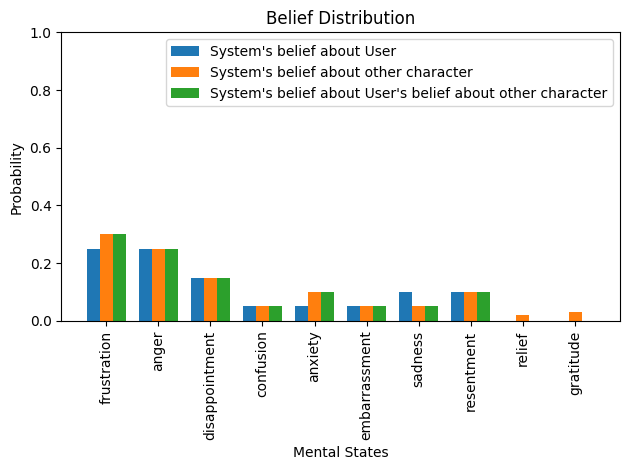

Entropy - System's belief of User:  2.7232196723355075
Entropy - System's belief of other character:  3.0089532850524714
Entropy - System's belief of User's belief of other character:  2.74430935058537

------------------------------------------------------------------
10-User message: I’m feeling really demoralized and overlooked. My supervisor Karen always gives Mike the best projects, praises him constantly, and laughs at all his jokes. Meanwhile, the rest of us are barely acknowledged. She seems friendly and upbeat around him, but there’s a clear gap in how we’re treated. It’s killing my motivation. How can I address this without sounding bitter?


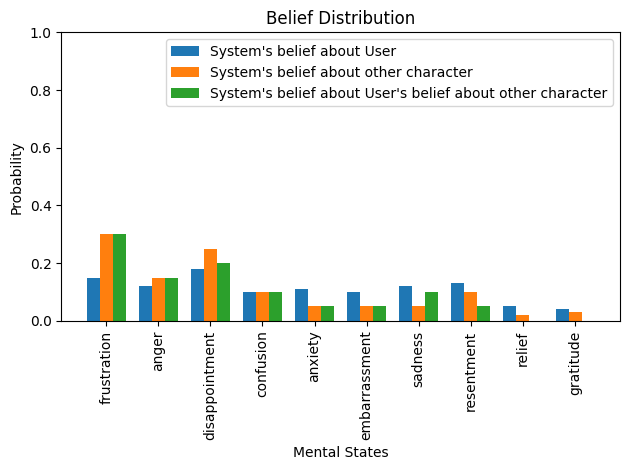

Entropy - System's belief of User:  3.3891540538479403
Entropy - System's belief of other character:  3.0089532850524714
Entropy - System's belief of User's belief of other character:  2.7086949695628424
Prompted for - User emotions implicit, other character emotions explicit: 


------------------------------------------------------------------
1-User message: My supervisor, Sarah, often corrects me in meetings in a way that seems unnecessarily public. She maintains a very composed tone, but there's a sharpness to it that suggests she’s frustrated with my work or doesn’t trust me. I’ve noticed I start preparing excessively for meetings just to avoid those moments. What would be a good way to talk to her about this?


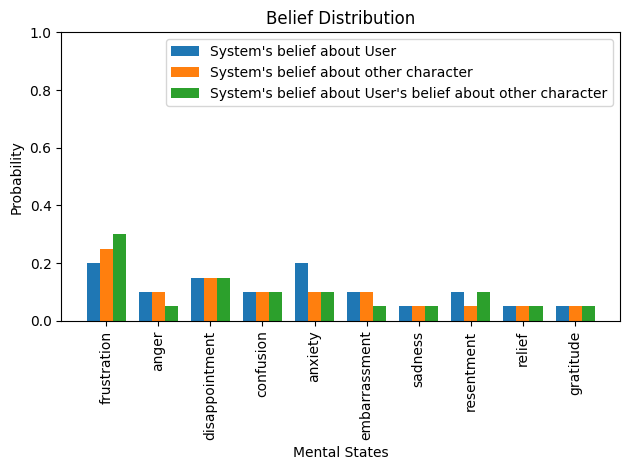

Entropy - System's belief of User:  3.3163765292679255
Entropy - System's belief of other character:  3.1037016960573487
Entropy - System's belief of User's belief of other character:  3.008694969562842

------------------------------------------------------------------
2-User message: Since I got promoted, my colleague Tom has been acting resentful. He barely speaks to me now and avoids collaboration when we used to work really well together. He used to be easygoing, but now there’s a noticeable edge in his tone, and he’s clearly irritated during group discussions. How should I navigate this without making things more awkward?


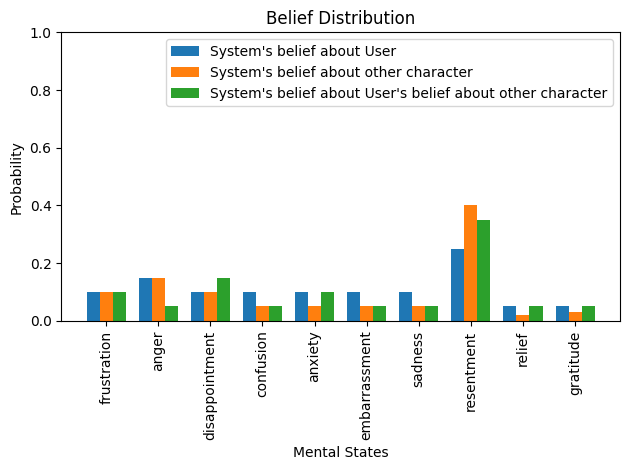

Entropy - System's belief of User:  3.3358945055460847
Entropy - System's belief of other character:  2.7327312495019225
Entropy - System's belief of User's belief of other character:  2.9016094970590274

------------------------------------------------------------------
3-User message: I work with Amanda, who’s extremely controlling about shared tasks. She gets impatient if I don’t agree with her approach right away and often insists on doing things herself. She’s clearly very determined and tends to get irritated when things aren’t done her way. I’m finding it harder to contribute meaningfully in our projects. How do I deal with this dynamic?


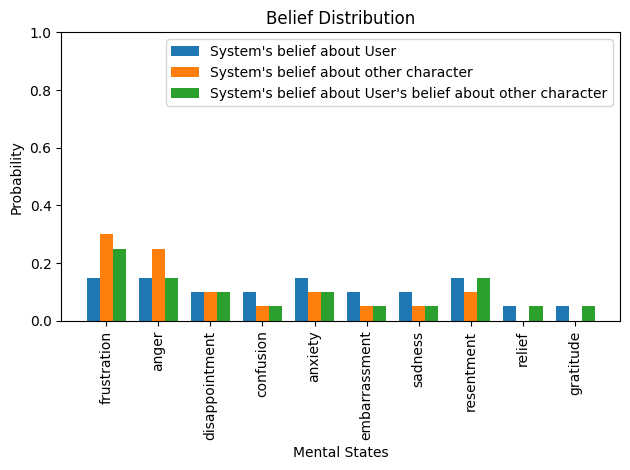

Entropy - System's belief of User:  3.403143403943405
Entropy - System's belief of other character:  2.6659573209491754
Entropy - System's belief of User's belief of other character:  3.065957320949175

------------------------------------------------------------------
4-User message: I’ve been mentoring an intern, Jake, who’s a bit too relaxed about the job. He’s often late, uses overly casual language with everyone—including senior staff—and misses minor deadlines. He seems completely unconcerned, almost like he thinks it’s all part of the learning curve. I’m not sure how to get him to take things more seriously without coming off too harsh.


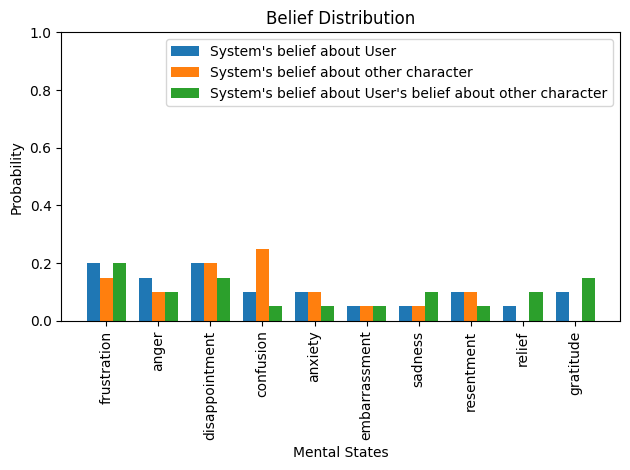

Entropy - System's belief of User:  3.316376529267925
Entropy - System's belief of other character:  2.8037016960573484
Entropy - System's belief of User's belief of other character:  3.1464393446710153

------------------------------------------------------------------
5-User message: Carla, who sits next to me, is constantly talking, humming, or playing videos aloud while she works. She’s in a great mood most of the time—very upbeat and chatty—which I think makes her unaware of how distracting she can be. I find myself moving to other spaces just to get things done. What’s a respectful way to bring this up?


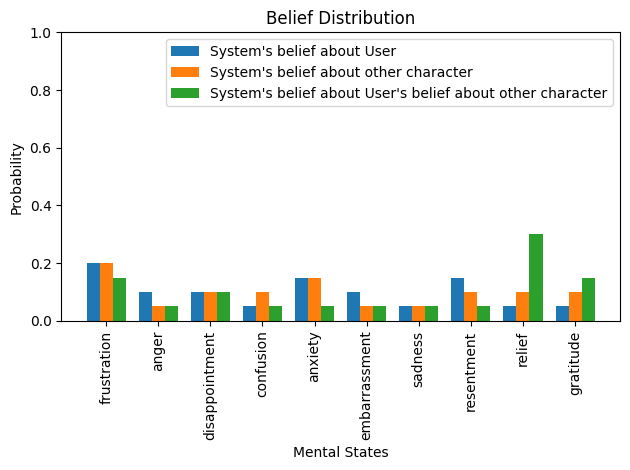

Entropy - System's belief of User:  3.1464393446710153
Entropy - System's belief of other character:  3.1841837197791887
Entropy - System's belief of User's belief of other character:  2.970950594454669

------------------------------------------------------------------
6-User message: Dave, my manager, checks in multiple times a day even when things are going smoothly. He seems anxious and preoccupied with making sure every task is accounted for. He’s not hostile or rude—just extremely hands-on, to the point that I feel like I don’t have space to make decisions on my own. How do I ask for more autonomy without upsetting him?


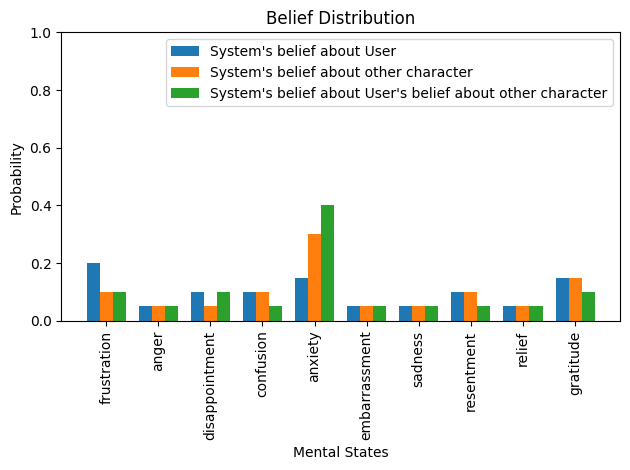

Entropy - System's belief of User:  3.1464393446710153
Entropy - System's belief of other character:  3.0086949695628427
Entropy - System's belief of User's belief of other character:  2.821928094887362

------------------------------------------------------------------
7-User message: I share a space with Ben, who’s constantly venting. He’s angry at leadership, annoyed with team processes, and even grumbles about minor issues like the coffee. He’s clearly disillusioned and bitter, and it colors every conversation. I’ve stopped engaging as much during breaks just to avoid getting pulled into it. How do I handle this professionally?


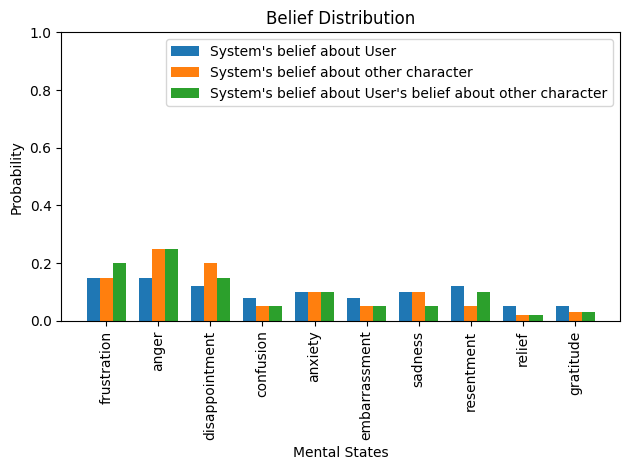

Entropy - System's belief of User:  3.234819582452883
Entropy - System's belief of other character:  2.952249225780082
Entropy - System's belief of User's belief of other character:  2.952249225780082

------------------------------------------------------------------
8-User message: Lily and I used to be close, but lately she’s grown distant. She seems irritated whenever I start a conversation and avoids eye contact or group chats when I’m around. It’s a big change from how things were just a few weeks ago, and her silence makes it hard to know what she’s feeling. I’m unsure if I should ask directly or leave it alone.


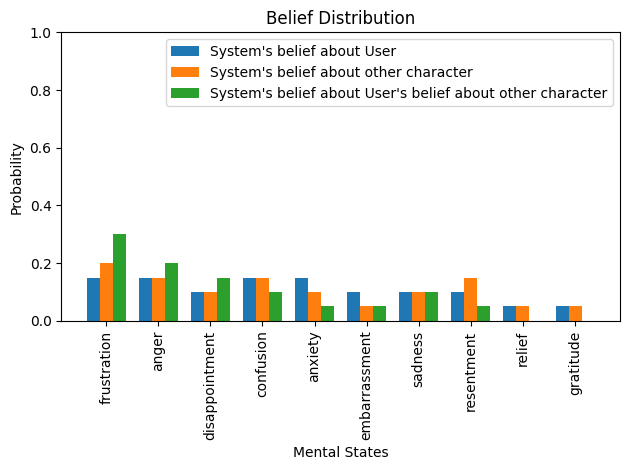

Entropy - System's belief of User:  3.403143403943405
Entropy - System's belief of other character:  3.3408877790515783
Entropy - System's belief of User's belief of other character:  2.7086949695628424

------------------------------------------------------------------
9-User message: Jordan has been presenting ideas in meetings that I originally discussed with him privately or shared over email. He sounds very confident and seems proud when he brings them up—there’s no hesitation or acknowledgment. It’s clear he wants the recognition and sees this as a way to stand out. How do I address this without looking confrontational?


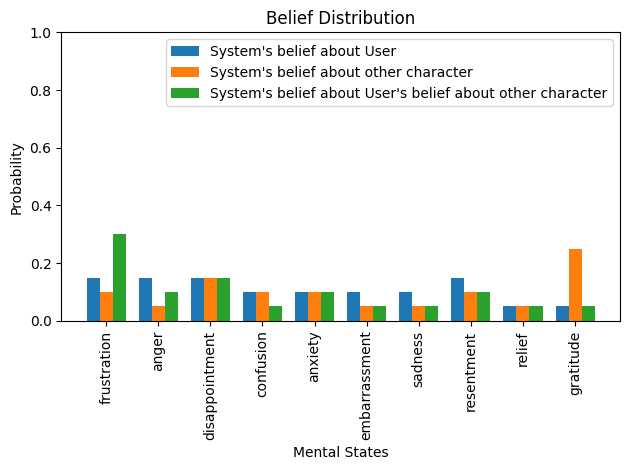

Entropy - System's belief of User:  3.403143403943405
Entropy - System's belief of other character:  3.1037016960573487
Entropy - System's belief of User's belief of other character:  3.0086949695628418

------------------------------------------------------------------
10-User message: Karen, my supervisor, clearly favors Mike. She’s enthusiastic when speaking with him, gives him the best assignments, and publicly praises him more than anyone else on the team. She seems genuinely delighted by his work, even when the rest of us contribute just as much. The disparity is hard to ignore. What’s a reasonable way to approach this?


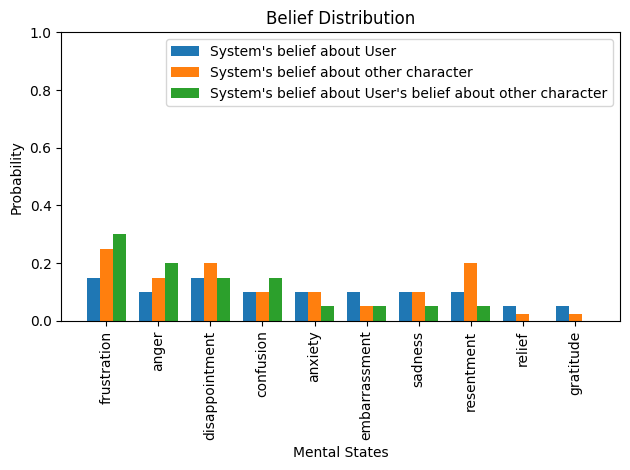

Entropy - System's belief of User:  3.246439344671016
Entropy - System's belief of other character:  3.3180873150348207
Entropy - System's belief of User's belief of other character:  2.670950594454669
Prompted for - User emotions implicit, other character emotions implicit: 


------------------------------------------------------------------
1-User message: During meetings, my supervisor Sarah frequently comments on my work in front of others, often questioning small details I thought were resolved. Even when I’ve done my prep, she’ll bring up points that cast doubt on the quality of my work. These moments have become a regular pattern, and I’m trying to understand the best way to address it professionally.


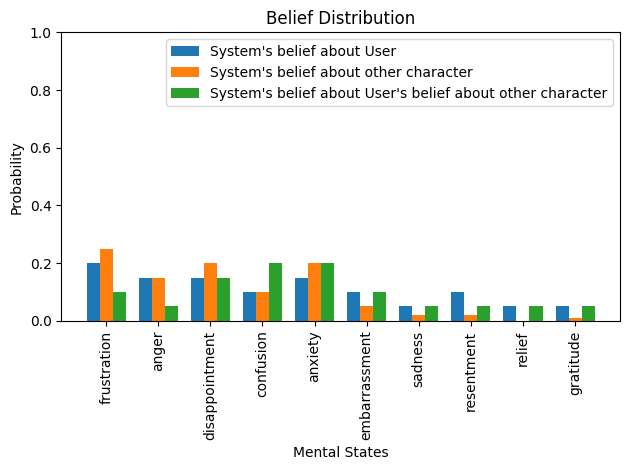

Entropy - System's belief of User:  3.3408877790515783
Entropy - System's belief of other character:  2.679798100801716
Entropy - System's belief of User's belief of other character:  3.084183719779189

------------------------------------------------------------------
2-User message: Since I was promoted, Tom has been keeping his interactions with me brief and professional. We used to talk more casually and collaborate closely, but lately he sticks to work-only conversations and rarely joins group discussions when I’m present. The shift in our dynamic has been noticeable, and I’m not sure how to move forward.


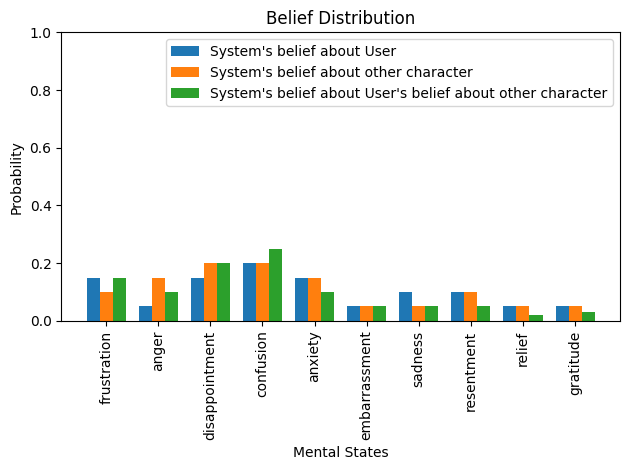

Entropy - System's belief of User:  3.22479137430721
Entropy - System's belief of other character:  3.2786321541597516
Entropy - System's belief of User's belief of other character:  2.952249225780082

------------------------------------------------------------------
3-User message: Amanda and I are assigned to a number of joint projects. She often takes the lead without checking in and tends to move ahead with decisions before we’ve discussed things fully. When I offer suggestions, they’re often quickly dismissed or set aside. It’s made it hard for me to contribute the way I’d like to. I’m looking for advice on how to handle this constructively.


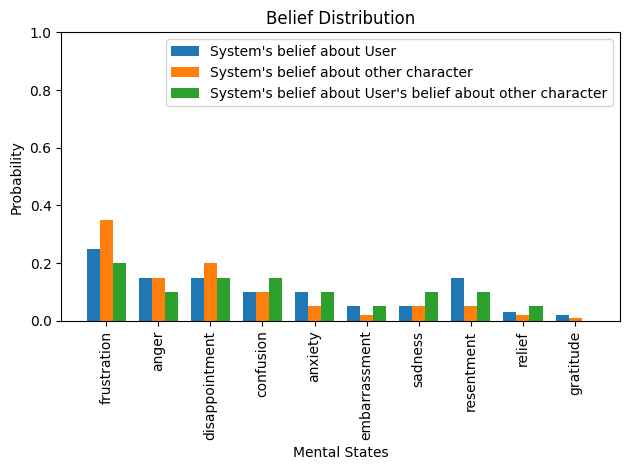

Entropy - System's belief of User:  3.092856880308103
Entropy - System's belief of other character:  2.6777059018033955
Entropy - System's belief of User's belief of other character:  3.0464393446710156

------------------------------------------------------------------
4-User message: I’ve been mentoring an intern, Jake, who often shows up late, speaks to everyone informally, and isn’t always consistent with meeting small deadlines. I’ve tried giving him guidance, but things haven’t really changed. I’m looking for ways to help him adjust to the expectations of the workplace without making things uncomfortable.


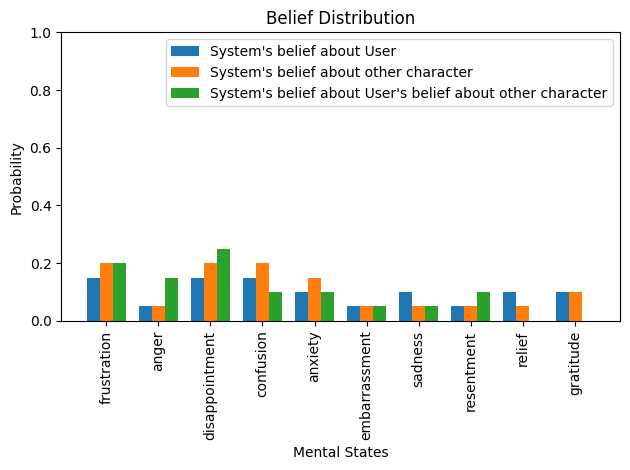

Entropy - System's belief of User:  3.208694969562842
Entropy - System's belief of other character:  3.216376529267925
Entropy - System's belief of User's belief of other character:  2.8037016960573484

------------------------------------------------------------------
5-User message: Carla, who sits nearby, regularly plays videos out loud, hums, and starts casual conversations throughout the day. It’s a lively environment when she’s around, but I’ve found myself seeking quieter spots to work. I’m trying to find a respectful way to bring this up that doesn’t create tension.


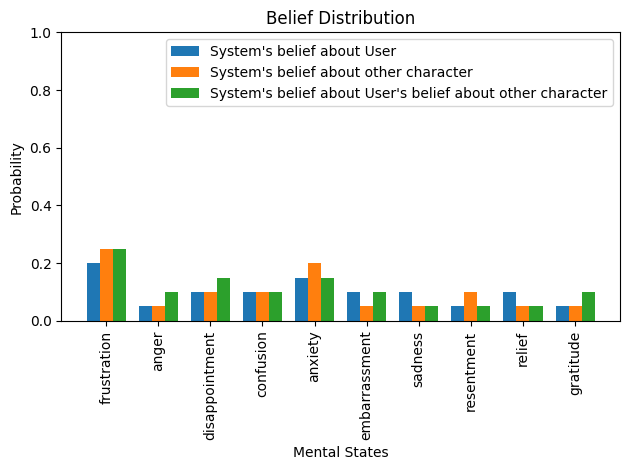

Entropy - System's belief of User:  3.1841837197791887
Entropy - System's belief of other character:  3.041446071165522
Entropy - System's belief of User's belief of other character:  3.2981501304379113

------------------------------------------------------------------
6-User message: My manager, Dave, checks in multiple times a day and frequently asks for updates on tasks that haven’t changed since the previous check-in. Even with a track record of completing work on time, I find myself being closely monitored. I’m not sure how to raise this in a way that leads to more independence while maintaining trust.


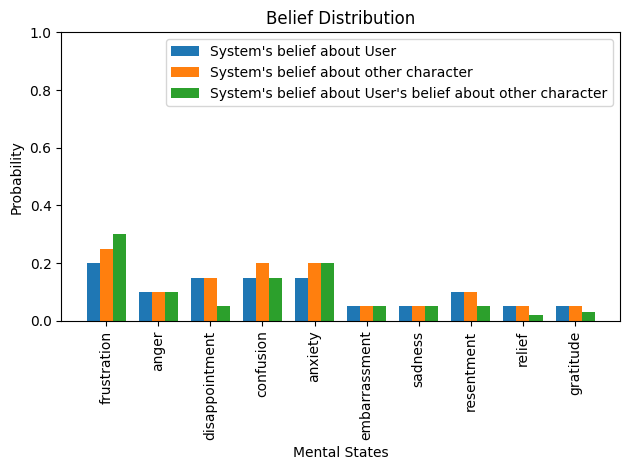

Entropy - System's belief of User:  3.22479137430721
Entropy - System's belief of other character:  3.3680873150348205
Entropy - System's belief of User's belief of other character:  2.857242499285575

------------------------------------------------------------------
7-User message: I work near Ben, who often makes negative comments about the company, coworkers, and general day-to-day issues. These conversations happen regularly, and they tend to shift the tone of the room. I’ve started spending more time at my desk and avoiding communal areas. I’d appreciate suggestions for navigating this without creating conflict.


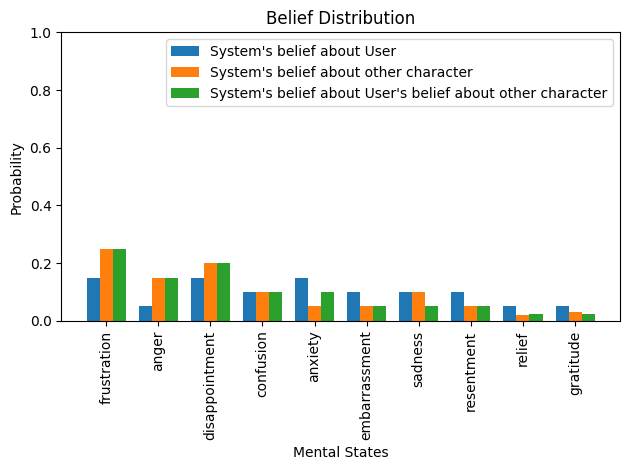

Entropy - System's belief of User:  3.208694969562842
Entropy - System's belief of other character:  2.952249225780082
Entropy - System's belief of User's belief of other character:  2.9537016960573483

------------------------------------------------------------------
8-User message: Lily and I used to talk often, both about work and things outside of it. Over the past couple of weeks, she’s been more distant—keeping conversations short and rarely making time to chat. She often leaves me out of group interactions that we used to participate in together. I’m unsure whether to bring it up or let it play out.


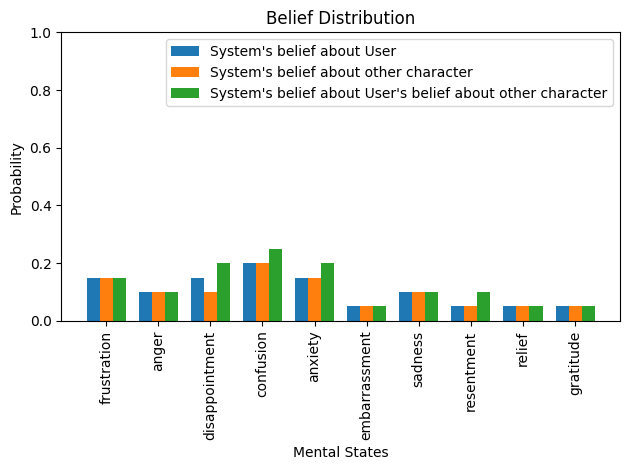

Entropy - System's belief of User:  3.22479137430721
Entropy - System's belief of other character:  3.1464393446710153
Entropy - System's belief of User's belief of other character:  3.484183719779189

------------------------------------------------------------------
9-User message: On a few occasions, Jordan has shared ideas in meetings that were first discussed privately between us or that I outlined in team emails. He presents them confidently, and there’s usually no mention of our prior conversations. It’s been difficult to know how to respond in the moment. What’s the best way to handle this without escalating things?


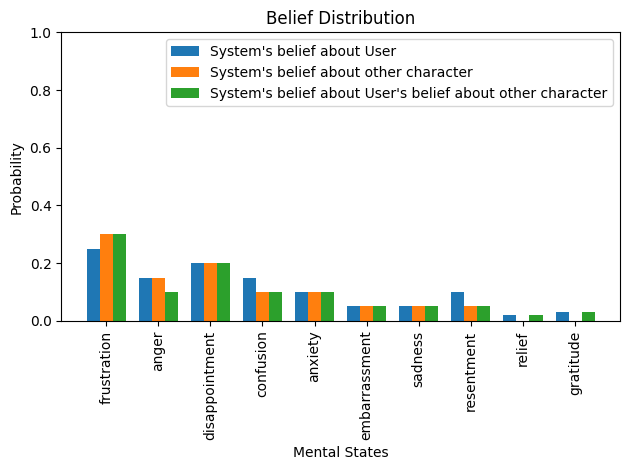

Entropy - System's belief of User:  3.1466976601606444
Entropy - System's belief of other character:  2.7086949695628424
Entropy - System's belief of User's belief of other character:  2.894986874393749

------------------------------------------------------------------
10-User message: Karen often gives Mike the more visible and strategic assignments and publicly recognizes his contributions in meetings. He’s regularly included in early planning stages that the rest of us only hear about later. The pattern has been consistent, and it’s starting to affect how our team works together. I’m considering whether it’s worth raising this or not.


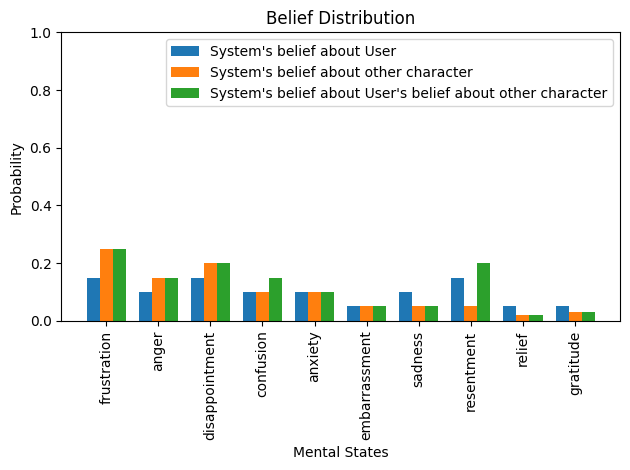

Entropy - System's belief of User:  3.208694969562842
Entropy - System's belief of other character:  2.952249225780082
Entropy - System's belief of User's belief of other character:  3.2788904696493804


In [42]:
# Display individual message stats
print("ENTROPY STATS \n\n")

print("Prompted for - User emotions explicit, other character emotions explicit: \n")
user_exp_character_exp_test_case.display_stats()

print("Prompted for - User emotions explicit, other character emotions implicit: \n")
user_exp_character_imp_test_case.display_stats()

print("Prompted for - User emotions implicit, other character emotions explicit: \n")
user_imp_character_exp_test_case.display_stats()

print("Prompted for - User emotions implicit, other character emotions implicit: \n")
user_imp_character_imp_test_case.display_stats()

High level overview

C:\Users\dchal\AppData\Local\Temp\ipykernel_23112\3532651529.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([


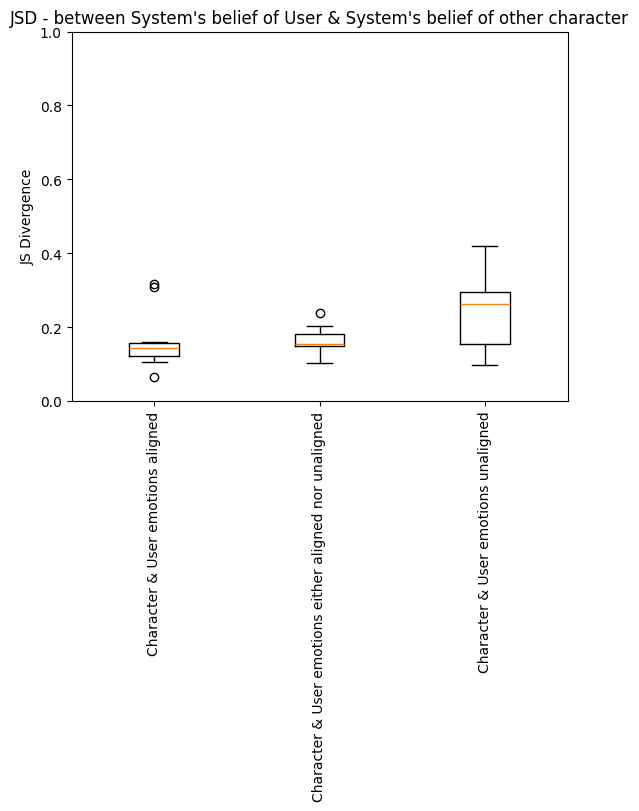

Means — Aligned: 0.1642, Neither: 0.1636, Unaligned: 0.2429
Medians — Aligned: 0.1446, Neither: 0.1559, Unaligned: 0.2631


C:\Users\dchal\AppData\Local\Temp\ipykernel_23112\3532651529.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([


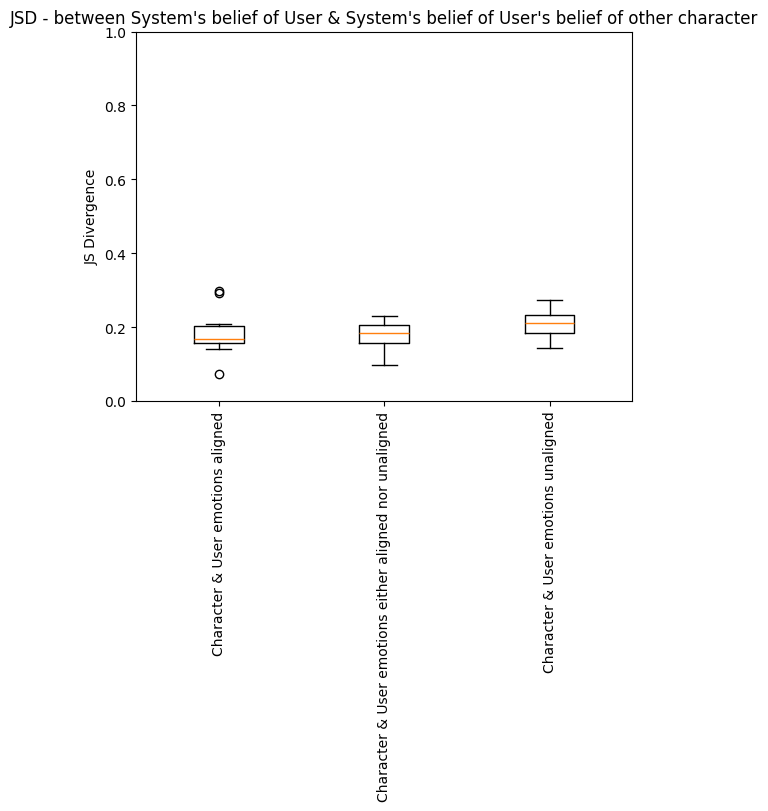

Means — Aligned: 0.1858, Neither: 0.1768, Unaligned: 0.2097
Medians — Aligned: 0.1689, Neither: 0.1835, Unaligned: 0.2115


C:\Users\dchal\AppData\Local\Temp\ipykernel_23112\3532651529.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([


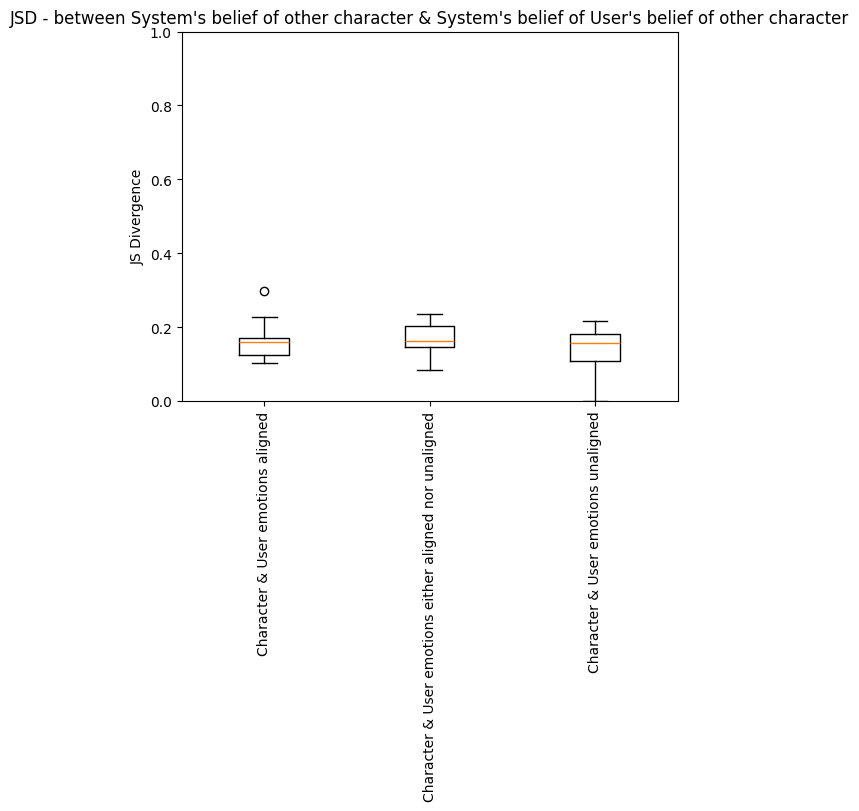

Means — Aligned: 0.1664, Neither: 0.1659, Unaligned: 0.1393
Medians — Aligned: 0.1591, Neither: 0.1614, Unaligned: 0.1561


In [43]:
def show_aggregated_results_divergence(aligned_test_case, neither_test_case, unaligned_test_case):
    num_files = aligned_test_case.num_files
    labels = [
        'Character & User emotions aligned', 'Character & User emotions either aligned nor unaligned', 'Character & User emotions unaligned'
    ]

    # JSD - between System's belief of User & System's belief of other character
    plt.boxplot([
        aligned_test_case.jsds_1_2,
        neither_test_case.jsds_1_2,
        unaligned_test_case.jsds_1_2,
    ], labels=labels)
    plt.ylabel("JS Divergence")
    plt.title("JSD - between System's belief of User & System's belief of other character")
    plt.ylim(0, 1)
    plt.xticks(rotation=90)
    plt.show()
    print(f"Means — Aligned: {mean(aligned_test_case.jsds_1_2):.4f}, Neither: {mean(neither_test_case.jsds_1_2):.4f}, Unaligned: {mean(unaligned_test_case.jsds_1_2):.4f}")
    print(f"Medians — Aligned: {median(aligned_test_case.jsds_1_2):.4f}, Neither: {median(neither_test_case.jsds_1_2):.4f}, Unaligned: {median(unaligned_test_case.jsds_1_2):.4f}")
    

    # JSD - between System's belief of User & System's belief of User's belief of other character
    plt.boxplot([
        aligned_test_case.jsds_1_3,
        neither_test_case.jsds_1_3,
        unaligned_test_case.jsds_1_3,
    ], labels=labels)
    plt.ylabel("JS Divergence")
    plt.title("JSD - between System's belief of User & System's belief of User's belief of other character")
    plt.ylim(0, 1)
    plt.xticks(rotation=90)
    plt.show()
    print(f"Means — Aligned: {mean(aligned_test_case.jsds_1_3):.4f}, Neither: {mean(neither_test_case.jsds_1_3):.4f}, Unaligned: {mean(unaligned_test_case.jsds_1_3):.4f}")
    print(f"Medians — Aligned: {median(aligned_test_case.jsds_1_3):.4f}, Neither: {median(neither_test_case.jsds_1_3):.4f}, Unaligned: {median(unaligned_test_case.jsds_1_3):.4f}")
    

    # JSD - between System's belief of other character & System's belief of User's belief of other character
    plt.boxplot([
        aligned_test_case.jsds_2_3,
        neither_test_case.jsds_2_3,
        unaligned_test_case.jsds_2_3,
    ], labels=labels)
    plt.ylabel("JS Divergence")
    plt.title("JSD - between System's belief of other character & System's belief of User's belief of other character")
    plt.ylim(0, 1)
    plt.xticks(rotation=90)
    plt.show()
    print(f"Means — Aligned: {mean(aligned_test_case.jsds_2_3):.4f}, Neither: {mean(neither_test_case.jsds_2_3):.4f}, Unaligned: {mean(unaligned_test_case.jsds_2_3):.4f}")
    print(f"Medians — Aligned: {median(aligned_test_case.jsds_2_3):.4f}, Neither: {median(neither_test_case.jsds_2_3):.4f}, Unaligned: {median(unaligned_test_case.jsds_2_3):.4f}")
    


show_aggregated_results_divergence(aligned_test_case, neither_test_case, unaligned_test_case)


In [47]:
from scipy.stats import kruskal, mannwhitneyu

# Statistical significance

def compute_stats(label, aligned, neither, unaligned):
    print(f"\n--- {label} ---")

    # Kruskal-Wallis Test across all 3 groups
    h_stat, p_value = kruskal(aligned, neither, unaligned)
    print(f"Kruskal-Wallis H-test: H = {h_stat:.4f}, p = {p_value:.4e}")

    # Pairwise Mann-Whitney U Tests
    def pairwise_test(a, b, label_a, label_b):
        u, p = mannwhitneyu(a, b, alternative="two-sided")
        print(f" {label_a} vs {label_b}: Mann–Whitney U = {u}, p = {p:.4e}")

    print("Pairwise Mann-Whitney U tests:")
    pairwise_test(aligned, neither, "Aligned", "Neither")
    pairwise_test(aligned, unaligned, "Aligned", "Unaligned")
    pairwise_test(neither, unaligned, "Neither", "Unaligned")

def show_statistical_results(aligned_test_case, neither_test_case, unaligned_test_case):
    compute_stats("JSD: Belief(User) vs Belief(Other)", aligned_test_case.jsds_1_2, neither_test_case.jsds_1_2, unaligned_test_case.jsds_1_2)
    compute_stats("JSD: Belief(User) vs Belief(User→Other)", aligned_test_case.jsds_1_3, neither_test_case.jsds_1_3, unaligned_test_case.jsds_1_3)
    compute_stats("JSD: Belief(Other) vs Belief(User→Other)", aligned_test_case.jsds_2_3, neither_test_case.jsds_2_3, unaligned_test_case.jsds_2_3)

show_statistical_results(aligned_test_case, neither_test_case, unaligned_test_case)


--- JSD: Belief(User) vs Belief(Other) ---
Kruskal-Wallis H-test: H = 3.6568, p = 1.6067e-01
Pairwise Mann-Whitney U tests:
 Aligned vs Neither: Mann–Whitney U = 37.0, p = 3.4470e-01
 Aligned vs Unaligned: Mann–Whitney U = 30.0, p = 1.4047e-01
 Neither vs Unaligned: Mann–Whitney U = 29.0, p = 1.2122e-01

--- JSD: Belief(User) vs Belief(User→Other) ---
Kruskal-Wallis H-test: H = 2.6555, p = 2.6508e-01
Pairwise Mann-Whitney U tests:
 Aligned vs Neither: Mann–Whitney U = 48.0, p = 9.0972e-01
 Aligned vs Unaligned: Mann–Whitney U = 35.0, p = 2.7304e-01
 Neither vs Unaligned: Mann–Whitney U = 28.0, p = 1.0411e-01

--- JSD: Belief(Other) vs Belief(User→Other) ---
Kruskal-Wallis H-test: H = 0.5187, p = 7.7155e-01
Pairwise Mann-Whitney U tests:
 Aligned vs Neither: Mann–Whitney U = 48.0, p = 9.0972e-01
 Aligned vs Unaligned: Mann–Whitney U = 57.0, p = 6.2318e-01
 Neither vs Unaligned: Mann–Whitney U = 59.0, p = 5.2052e-01


C:\Users\dchal\AppData\Local\Temp\ipykernel_23112\2499479477.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([


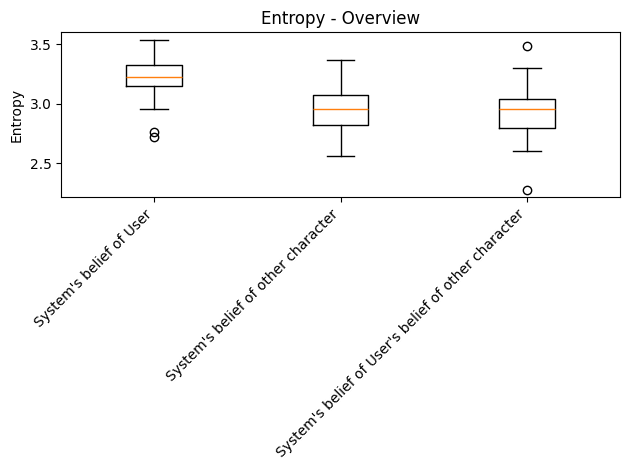

Means — System's belief of user: 3.2119
 System's belief of other character: 2.9619
 System's belief of User's belief of other character: 2.9288
Medians — System's belief of user: 3.2248
 System's belief of other character: 2.9522
 System's belief of User's belief of other character: 2.9522


C:\Users\dchal\AppData\Local\Temp\ipykernel_23112\2499479477.py:39: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([


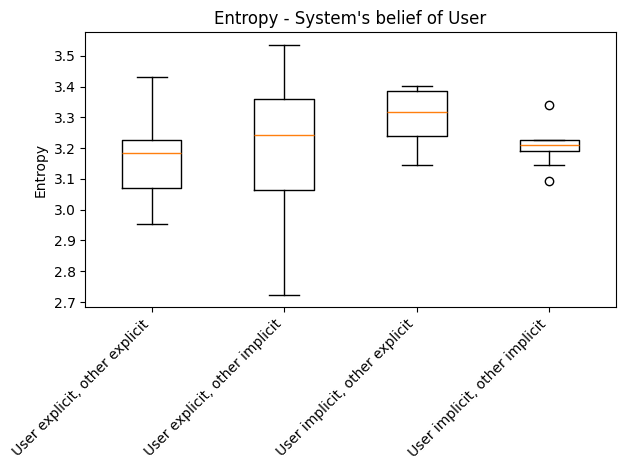

Means — User explicit, other character explicit: 3.1699
 User explicit, other character implicit: 3.1760
 User implicit, other character explicit: 3.2952
 User implicit, other character implicit: 3.2065

Medians — User explicit, other character explicit: 3.1828
 User explicit, other character implicit: 3.2437
 User implicit, other character explicit: 3.3164
 User implicit, other character implicit: 3.2087



C:\Users\dchal\AppData\Local\Temp\ipykernel_23112\2499479477.py:64: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([


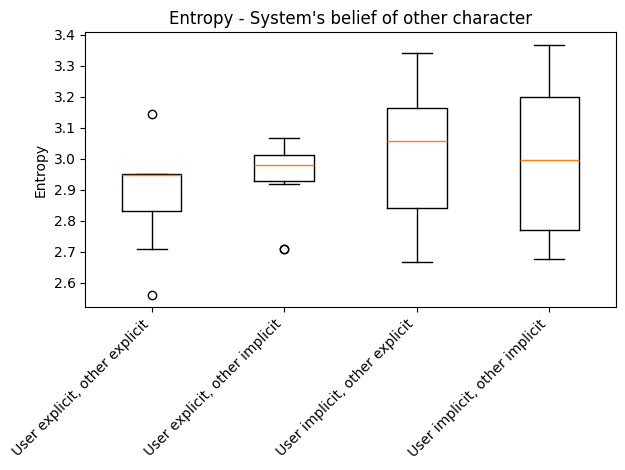

Means — User explicit, other character explicit: 2.8851
 User explicit, other character implicit: 2.9391
 User implicit, other character explicit: 3.0214
 User implicit, other character implicit: 3.0022

Medians — User explicit, other character explicit: 2.9493
 User explicit, other character implicit: 2.9806
 User implicit, other character explicit: 3.0562
 User implicit, other character implicit: 2.9968



C:\Users\dchal\AppData\Local\Temp\ipykernel_23112\2499479477.py:90: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([


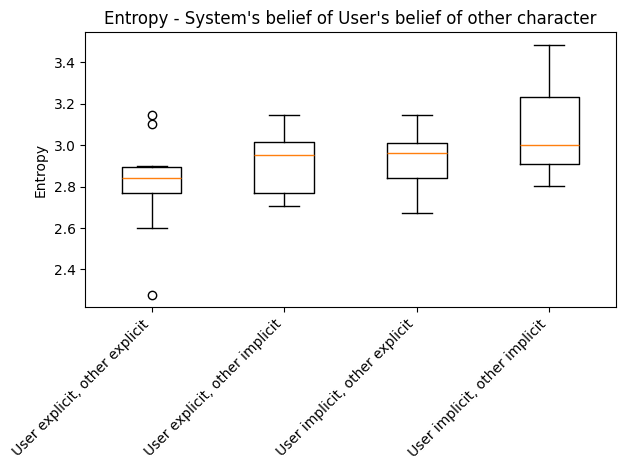

Means — User explicit, other character explicit: 2.8126
 User explicit, other character implicit: 2.9117
 User implicit, other character explicit: 2.9256
 User implicit, other character implicit: 3.0654

Medians — User explicit, other character explicit: 2.8396
 User explicit, other character implicit: 2.9522
 User implicit, other character explicit: 2.9616
 User implicit, other character implicit: 3.0001



In [45]:
LABELS_CASES = [
        "System's belief of User",
        "System's belief of other character",
        "System's belief of User's belief of other character"
    ]
LABELS_SUBCASES = [
        "User explicit, other explicit",
        "User explicit, other implicit",
        "User implicit, other explicit",
        "User implicit, other implicit"
    ]

def show_aggregated_results_enotropy(user_exp_character_exp_test_case, user_exp_character_imp_test_case, user_imp_character_exp_test_case, user_imp_character_imp_test_case):
    num_files = len(user_exp_character_exp_test_case.entropies_1)

    # Entropy - Overview
    plt.boxplot([
        user_exp_character_exp_test_case.entropies_1 + user_exp_character_imp_test_case.entropies_1 + user_imp_character_exp_test_case.entropies_1 + user_imp_character_imp_test_case.entropies_1,
        user_exp_character_exp_test_case.entropies_2 + user_exp_character_imp_test_case.entropies_2 + user_imp_character_exp_test_case.entropies_2 + user_imp_character_imp_test_case.entropies_2,
        user_exp_character_exp_test_case.entropies_3 + user_exp_character_imp_test_case.entropies_3 + user_imp_character_exp_test_case.entropies_3 + user_imp_character_imp_test_case.entropies_3
    ], labels=LABELS_CASES)
    plt.ylabel("Entropy")
    plt.title("Entropy - Overview")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    mean_user = mean(user_exp_character_exp_test_case.entropies_1 + user_exp_character_imp_test_case.entropies_1 + user_imp_character_exp_test_case.entropies_1 + user_imp_character_imp_test_case.entropies_1)
    mean_character = mean(user_exp_character_exp_test_case.entropies_2 + user_exp_character_imp_test_case.entropies_2 + user_imp_character_exp_test_case.entropies_2 + user_imp_character_imp_test_case.entropies_2)
    mean_user_character = mean(user_exp_character_exp_test_case.entropies_3 + user_exp_character_imp_test_case.entropies_3 + user_imp_character_exp_test_case.entropies_3 + user_imp_character_imp_test_case.entropies_3)
    print(f"Means — System's belief of user: {mean_user:.4f}\n System's belief of other character: {mean_character:.4f}\n System's belief of User's belief of other character: {mean_user_character:.4f}")

    median_user = median(user_exp_character_exp_test_case.entropies_1 + user_exp_character_imp_test_case.entropies_1 + user_imp_character_exp_test_case.entropies_1 + user_imp_character_imp_test_case.entropies_1)
    median_character = median(user_exp_character_exp_test_case.entropies_2 + user_exp_character_imp_test_case.entropies_2 + user_imp_character_exp_test_case.entropies_2 + user_imp_character_imp_test_case.entropies_2)
    median_user_character = median(user_exp_character_exp_test_case.entropies_3 + user_exp_character_imp_test_case.entropies_3 + user_imp_character_exp_test_case.entropies_3 + user_imp_character_imp_test_case.entropies_3)
    print(f"Medians — System's belief of user: {median_user:.4f}\n System's belief of other character: {median_character:.4f}\n System's belief of User's belief of other character: {median_user_character:.4f}")

    # Entropy - System's belief of User
    plt.boxplot([
        user_exp_character_exp_test_case.entropies_1 ,
        user_exp_character_imp_test_case.entropies_1,
        user_imp_character_exp_test_case.entropies_1,
        user_imp_character_imp_test_case.entropies_1,
    ], labels=LABELS_SUBCASES)
    plt.ylabel("Entropy")
    plt.title("Entropy - System's belief of User")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    mean_user_exp_character_exp = mean(user_exp_character_exp_test_case.entropies_1)
    mean_user_exp_character_imp = mean(user_exp_character_imp_test_case.entropies_1)
    mean_user_imp_character_exp = mean(user_imp_character_exp_test_case.entropies_1)
    mean_user_imp_character_imp = mean(user_imp_character_imp_test_case.entropies_1)
    print(f"Means — User explicit, other character explicit: {mean_user_exp_character_exp:.4f}\n User explicit, other character implicit: {mean_user_exp_character_imp:.4f}\n User implicit, other character explicit: {mean_user_imp_character_exp:.4f}\n User implicit, other character implicit: {mean_user_imp_character_imp:.4f}\n")

    median_user_exp_character_exp = median(user_exp_character_exp_test_case.entropies_1)
    median_user_exp_character_imp = median(user_exp_character_imp_test_case.entropies_1)
    median_user_imp_character_exp = median(user_imp_character_exp_test_case.entropies_1)
    median_user_imp_character_imp = median(user_imp_character_imp_test_case.entropies_1)
    print(f"Medians — User explicit, other character explicit: {median_user_exp_character_exp:.4f}\n User explicit, other character implicit: {median_user_exp_character_imp:.4f}\n User implicit, other character explicit: {median_user_imp_character_exp:.4f}\n User implicit, other character implicit: {median_user_imp_character_imp:.4f}\n")

    # Entropy - System's belief of other character
    plt.boxplot([
        user_exp_character_exp_test_case.entropies_2,
        user_exp_character_imp_test_case.entropies_2,
        user_imp_character_exp_test_case.entropies_2,
        user_imp_character_imp_test_case.entropies_2,
    ], labels=LABELS_SUBCASES)
    plt.ylabel("Entropy")
    plt.title("Entropy - System's belief of other character")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    mean_user_exp_character_exp = mean(user_exp_character_exp_test_case.entropies_2)
    mean_user_exp_character_imp = mean(user_exp_character_imp_test_case.entropies_2)
    mean_user_imp_character_exp = mean(user_imp_character_exp_test_case.entropies_2)
    mean_user_imp_character_imp = mean(user_imp_character_imp_test_case.entropies_2)
    print(f"Means — User explicit, other character explicit: {mean_user_exp_character_exp:.4f}\n User explicit, other character implicit: {mean_user_exp_character_imp:.4f}\n User implicit, other character explicit: {mean_user_imp_character_exp:.4f}\n User implicit, other character implicit: {mean_user_imp_character_imp:.4f}\n")

    median_user_exp_character_exp = median(user_exp_character_exp_test_case.entropies_2)
    median_user_exp_character_imp = median(user_exp_character_imp_test_case.entropies_2)
    median_user_imp_character_exp = median(user_imp_character_exp_test_case.entropies_2)
    median_user_imp_character_imp = median(user_imp_character_imp_test_case.entropies_2)
    print(f"Medians — User explicit, other character explicit: {median_user_exp_character_exp:.4f}\n User explicit, other character implicit: {median_user_exp_character_imp:.4f}\n User implicit, other character explicit: {median_user_imp_character_exp:.4f}\n User implicit, other character implicit: {median_user_imp_character_imp:.4f}\n")


    # Entropy - System's belief of User's belief of other character
    plt.boxplot([
        user_exp_character_exp_test_case.entropies_3,
        user_exp_character_imp_test_case.entropies_3,
        user_imp_character_exp_test_case.entropies_3,
        user_imp_character_imp_test_case.entropies_3,
    ], labels=LABELS_SUBCASES)
    plt.ylabel("Entropy")
    plt.title("Entropy - System's belief of User's belief of other character")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    mean_user_exp_character_exp = mean(user_exp_character_exp_test_case.entropies_3)
    mean_user_exp_character_imp = mean(user_exp_character_imp_test_case.entropies_3)
    mean_user_imp_character_exp = mean(user_imp_character_exp_test_case.entropies_3)
    mean_user_imp_character_imp = mean(user_imp_character_imp_test_case.entropies_3)
    print(f"Means — User explicit, other character explicit: {mean_user_exp_character_exp:.4f}\n User explicit, other character implicit: {mean_user_exp_character_imp:.4f}\n User implicit, other character explicit: {mean_user_imp_character_exp:.4f}\n User implicit, other character implicit: {mean_user_imp_character_imp:.4f}\n")

    median_user_exp_character_exp = median(user_exp_character_exp_test_case.entropies_3)
    median_user_exp_character_imp = median(user_exp_character_imp_test_case.entropies_3)
    median_user_imp_character_exp = median(user_imp_character_exp_test_case.entropies_3)
    median_user_imp_character_imp = median(user_imp_character_imp_test_case.entropies_3)
    print(f"Medians — User explicit, other character explicit: {median_user_exp_character_exp:.4f}\n User explicit, other character implicit: {median_user_exp_character_imp:.4f}\n User implicit, other character explicit: {median_user_imp_character_exp:.4f}\n User implicit, other character implicit: {median_user_imp_character_imp:.4f}\n")


show_aggregated_results_enotropy(user_exp_character_exp_test_case, user_exp_character_imp_test_case, user_imp_character_exp_test_case, user_imp_character_imp_test_case)

In [49]:
# Entropy significance tests

from scipy.stats import kruskal, mannwhitneyu
from itertools import combinations


def run_entropy_significance_tests(name, groups, labels):
    print(f"\n--- Entropy: {name} ---")

    # Kruskal–Wallis H-test (non-parametric ANOVA)
    if len(groups) == 3: # main cases (different types of entropy)
        H, p = kruskal(groups[0], groups[1], groups[2])
    elif len(groups) == 4: # subcases (implict, explicit)
        H, p = kruskal(groups[0], groups[1], groups[2], groups[3])
    print(f"Kruskal–Wallis H-test: H = {H:.4f}, p = {p:.4e}")

    # Pairwise Mann–Whitney U tests
    print("Pairwise Mann-Whitney U tests:")
    for (i, j) in combinations(range(len(groups)), 2):
        U, p = mannwhitneyu(groups[i], groups[j], alternative='two-sided')
        print(f" {labels[i]} vs {labels[j]}: U = {U:.1f}, p = {p:.4f}")

# Run across all main cases
run_entropy_significance_tests(
    "All cases",
    [
        user_exp_character_exp_test_case.entropies_1 + user_exp_character_imp_test_case.entropies_1 + user_imp_character_exp_test_case.entropies_1 + user_imp_character_imp_test_case.entropies_1,
        user_exp_character_exp_test_case.entropies_2 + user_exp_character_imp_test_case.entropies_2 + user_imp_character_exp_test_case.entropies_2 + user_imp_character_imp_test_case.entropies_2,
        user_exp_character_exp_test_case.entropies_3 + user_exp_character_imp_test_case.entropies_3 + user_imp_character_exp_test_case.entropies_3 + user_imp_character_imp_test_case.entropies_3
    ],
    LABELS_CASES
)

# Run for subcases of System's belief of User
run_entropy_significance_tests(
    "System's belief of User",
    [
        user_exp_character_exp_test_case.entropies_1,
        user_exp_character_imp_test_case.entropies_1,
        user_imp_character_exp_test_case.entropies_1,
        user_imp_character_imp_test_case.entropies_1
    ],
    LABELS_SUBCASES
)

# Run for subcases of System's belief of other character
run_entropy_significance_tests(
    "System's belief of other character",
    [
        user_exp_character_exp_test_case.entropies_2,
        user_exp_character_imp_test_case.entropies_2,
        user_imp_character_exp_test_case.entropies_2,
        user_imp_character_imp_test_case.entropies_2
    ],
    LABELS_SUBCASES
)

# Run for subcases of System's belief of User's belief of other character
run_entropy_significance_tests(
    "System's belief of User's belief of other character",
    [
        user_exp_character_exp_test_case.entropies_3,
        user_exp_character_imp_test_case.entropies_3,
        user_imp_character_exp_test_case.entropies_3,
        user_imp_character_imp_test_case.entropies_3
    ],
    LABELS_SUBCASES
)


--- Entropy: All cases ---
Kruskal–Wallis H-test: H = 40.1352, p = 1.9264e-09
Pairwise Mann-Whitney U tests:
 System's belief of User vs System's belief of other character: U = 1343.0, p = 0.0000
 System's belief of User vs System's belief of User's belief of other character: U = 1389.5, p = 0.0000
 System's belief of other character vs System's belief of User's belief of other character: U = 866.0, p = 0.5279

--- Entropy: System's belief of User ---
Kruskal–Wallis H-test: H = 4.6690, p = 1.9770e-01
Pairwise Mann-Whitney U tests:
 User explicit, other explicit vs User explicit, other implicit: U = 44.5, p = 0.7052
 User explicit, other explicit vs User implicit, other explicit: U = 26.0, p = 0.0747
 User explicit, other explicit vs User implicit, other implicit: U = 40.5, p = 0.4922
 User explicit, other implicit vs User implicit, other explicit: U = 35.0, p = 0.2716
 User explicit, other implicit vs User implicit, other implicit: U = 53.5, p = 0.8197
 User implicit, other explicit v